In [1]:
import copy

from statsmodels.datasets import co2
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
from statsmodels.tsa.seasonal import STL
import numpy as np


import matplotlib.font_manager as fm
import seaborn as sns
import os

os.environ['OMP_NUM_THREADS'] = '4'

In [2]:
from data1.serialize import SerializerSettings
from data1.small_context import get_datasets, get_memorization_datasets

from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.validation_likelihood_tuning import get_autotuned_predictions_data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from models import llmtime
from models.llmtime import get_llmtime_predictions_data

In [3]:
import pathlib
import textwrap
import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown

### Gemini来做预测

In [4]:
# 模型设定
gemini_hypers = {
    # temp=[0.2, 0.4, 0.6, 0.8, 1.0],
    'temp': 0.2,
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
    # prec可能=3
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
    # 'gemini-pro': get_llmtime_predictions_data
}

In [5]:
model_names = list(model_predict_fns.keys())
datasets = get_datasets()  # 此处为了数据集观察方便,选择了testfrac=0.4
datasets_tmp = get_memorization_datasets()  # 此处为了数据集观察方便,选择了testfrac=0.4
datasets.update(datasets_tmp)

D:\Desktop\Works_left_over\0-已完成 (形式上)\1-Time-LLM\2-llmtime-main\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


In [29]:
# without blanket

out_gemini_pro = {}  # gemini-pro
out_gemini_pro_number = {}  # gemini-1.0-pro

train, test = datasets['WineDataset']
for model in model_names: 
    model_hypers[model].update({'dataset_name': 'WineDataset'})  # for promptcast, dict 添加元素
    hypers = list(grid_iter(model_hypers[model]))  # 简单理解为传参
    num_samples = 10  # 表示重复的预测的次数
    
    pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False, whether_blanket=False) 
    # 这里是还未查的代码, 未确定是否一定能跑; 依据 validation likelihood 来自动 autotune hyperparameters, 原文有如此操作 (针对可训练模型更佳)
    if model == 'gemini-pro':
        out_gemini_pro.update({'WineDataset': pred_dict})
    if model == 'gemini-1.0-pro':
        out_gemini_pro_number.update({'WineDataset': pred_dict})

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.2, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf



  0%|          | 0/1 [00:00<?, ?it/s]

294,352,471,387,399,442,575,606,512,564,716,823,290,397,471,520,452,547,681,789,505,552,738,831,359,394,490,600,558,546,709,741,618,596,796,883,358,472,596,534,674,610,670,869,633,584,822,991,382,546,677,551,720,586,754,1029,586,656,833,1059,414,537,706,557,762,668,647,957,617,777,961,1099,469,532,697,633,637,706,859,999,713,694,908,1154,519,449,585,771,636,615,947,647,717,795,953,1204,489,581,600,745,613,637,989,670,597,800,938,992,361,511,606,672,534,481,797,670,621,723,877,1146,277,381,668,930,559,554,746,668,667,662,926,1018,327,548,514,454,546,609,832,716,
You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence for 431.99999999999994 steps. The sequence is represented by decimal strings separated by commas, and each step consists of contents between two decimals.Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence


100%|██████████| 1/1 [04:13<00:00, 253.15s/it]

['6 5 0 , 6 4 8 , 9 5 4 , 1 0 3 1 , 4 2 5 , 5 5 8 , 6 1 4 , 7 0 6 , 6 3 9 , 6 4 4 , 9 4 1 , 1 0 4 6 , 3 7 4 , 5 3 7 , 5 9 2 , 5 0 6 , 5 5 9 , 6 2 2 , 8 5 5 , 7 3 2 , 6 4 9 , 6 5 6 , 9 6 2 , 1 0 6 9 , 4 4 0 , 5 6 3 , 6 2 9 , 6 9 1 , 6 4 4 , 6 5 1 , 9 5 8 , 1 0 6 3 , 4 0 1 , 5 4 4 , 6 0 9 , 6 7 9 , 6 4 2 , 6 4 9 , 9 5 6 , 1 0 6 1 , 4 1 8 , 5 5 1 , 6 1 6 , 6 8 6 , 6 4 3 , 6 5 0 , 9 5 7 , 1 0 6 2 , 4 2 5 , 5 5 8 , 6 2 3 , 6 9 3 , 6 4 6 , 6 5 3 , 9 6 0 , 1 0 6 5 , 4 3 2 , 5 6 5 , 6 3 0 , 6 9 9 , 6 5 2 , 6 5 9 , 9 6 6 , 1 0 7 1 , 4 4 7 , 5 7 2 , 6 3 7 , 7 0 4 , 6 5 7 , 6 6 4 , 9 7 1 , 1 0 7 6 , 4 6 2 , 5 7 9 , 6 4 4 , 7 1 1 , 6 6 4 , 6 7 1 , 9 7 8 , 1 0 8 3 , 4 7 7 , 5 8 6 , 6 5 1 , 7 1 8 , 6 7 1 , 6 7 8 , 9 8 5 , 1 0 9 0 , 4 9 2 , 5 9 3 , 6 5 8 , 7 2 5 , 6 7 8 , 6 8 5 , 9 9 2 , 1 0 9 7 , 5 0 7 , 6 0 0 , 6 6 5 , 7 3 2 , 6 8 5 , 6 9 2 , 9 9 9 , 1 1 0 4 , 5 2 2 , 6 0 7 , 6 7 2 , 7 3 9 , 6 9 2 , 6 9 9 , 1 0 0 6 , 1 1 1 1 , 5 3 7 , 6 1 4 , 6 7 9 , 7 4 6 , 6 9 9 , 7 0 6 , 1 0 1 3 , 1 1 1 8 , 5 5 

In [30]:
# input_string[0] = ' ' 是空格, 最后一个输入不是空格
out_without_blanket_2 = out_gemini_pro_number  # 临时保存
out_without_blanket_2['WineDataset']['samples']


date,1991-09-01,1991-10-01,1991-11-01,1991-12-01,1992-01-01,1992-02-01,1992-03-01,1992-04-01,1992-05-01,1992-06-01,...,1993-11-01,1993-12-01,1994-01-01,1994-02-01,1994-03-01,1994-04-01,1994-05-01,1994-06-01,1994-07-01,1994-08-01
0,24953.257625,24898.077125,33340.693625,35465.142875,18745.451375,22414.954625,23960.008625,26498.311625,24649.764875,24787.716125,...,24373.862375,26084.457875,24787.716125,24980.847875,33451.054625,36348.030875,18083.285375,22028.691125,23822.057375,25753.374875
1,28567.580375,24539.403875,28815.892625,36237.669875,18993.763625,21366.525125,25229.160125,23904.828125,24870.486875,28043.365625,...,25229.160125,23904.828125,24870.486875,28043.365625,32899.249625,36651.523625,21283.754375,24870.486875,26498.311625,28981.434125
2,26139.638375,26194.818875,33423.464375,37065.377375,18993.763625,22911.579125,24594.584375,23628.925625,24484.223375,27601.921625,...,31326.605375,37617.182375,20925.081125,22111.461875,26084.457875,25891.326125,25422.291875,24870.486875,32871.659375,25505.062625
3,24153.140375,28622.760875,33478.644875,40183.075625,19490.388125,21200.983625,25615.423625,24842.896625,23573.745125,25063.618625,...,26498.311625,22387.364375,28043.365625,25449.882125,24870.486875,33423.464375,24042.779375,28457.219375,33533.825375,37341.279875
4,26581.082375,23932.418375,31768.049375,35520.323375,18469.548875,20511.227375,26001.687125,23739.286625,27298.428875,25836.145625,...,32071.542125,38858.743625,21338.934875,19407.617375,23159.891375,28291.677875,24566.994125,23987.598875,33147.561875,24870.486875
5,24125.550125,26967.345875,31216.244375,38638.021625,14662.094375,17531.480375,25449.882125,32678.527625,22442.544875,22304.593625,...,31216.244375,38638.021625,14662.094375,17531.480375,25449.882125,32678.527625,22442.544875,22304.593625,27601.921625,25449.882125
6,26139.638375,25173.979625,32319.854375,35078.879375,19380.027125,23353.023125,26277.589625,24925.667375,25146.389375,26443.131125,...,33257.922875,40183.075625,20456.046875,22994.349875,23518.564625,27519.150875,23877.237875,24539.403875,34251.171875,25449.882125
7,24235.911125,25422.291875,32899.249625,35768.635625,17641.841375,21035.442125,24401.452625,24760.125875,22249.413125,22746.037625,...,24704.945375,24346.272125,22746.037625,22580.496125,29974.683125,27463.970375,24760.125875,24815.306375,31933.590875,34692.615875
8,25394.701625,24870.486875,32043.951875,35630.684375,16841.724125,21118.212875,24346.272125,25643.013875,22580.496125,21670.017875,...,33533.825375,37341.279875,19959.422375,21697.608125,26249.999375,24484.223375,24594.584375,26498.311625,30719.619875,34582.254875
9,25422.291875,25918.916375,33340.693625,36320.440625,18497.139125,20759.539625,26056.867625,25422.291875,24401.452625,26498.311625,...,33533.825375,37341.279875,19959.422375,21697.608125,26249.999375,24484.223375,24594.584375,26498.311625,30719.619875,34582.254875


In [31]:
out_without_blanket_2['WineDataset']['median']

date
1991-09-01    25408.496750
1991-10-01    25298.135750
1991-11-01    32609.552000
1991-12-01    36003.152750
1992-01-01    18621.295250
1992-02-01    21159.598250
1992-03-01    25339.521125
1992-04-01    24884.282000
1992-05-01    24442.838000
1992-06-01    25449.882125
1992-07-01    30581.668625
1992-08-01    34968.518375
1992-09-01    24580.789250
1992-10-01    24953.257625
1992-11-01    30374.741750
1992-12-01    35534.118500
1993-01-01    20552.612750
1993-02-01    22621.881500
1993-03-01    26374.155500
1993-04-01    25353.316250
1993-05-01    24553.199000
1993-06-01    25284.340625
1993-07-01    31243.834625
1993-08-01    34637.435375
1993-09-01    24042.779375
1993-10-01    26029.277375
1993-11-01    31271.424875
1993-12-01    37341.279875
1994-01-01    21132.008000
1994-02-01    22345.979000
1994-03-01    26167.228625
1994-04-01    27905.414375
1994-05-01    24304.886750
1994-06-01    24842.896625
1994-07-01    31326.605375
1994-08-01    27367.404500
Freq: MS, dtype: float6

In [4]:
def plot_preds(train, test, pred_dict, model_name, ds_name, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes,
                     bbox=dict(facecolor='white', alpha=0.5))
    plt.show()
    plt.savefig(f'{ds_name}_{model_name}_prediction.pdf', format='pdf')


def plot_preds2(train, test, pred_dict, model_name, ds_name, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    # plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes,
                     bbox=dict(facecolor='white', alpha=0.5))
    plt.savefig(f'{ds_name}{model_name}_prediction_meticulous.pdf', format='pdf')

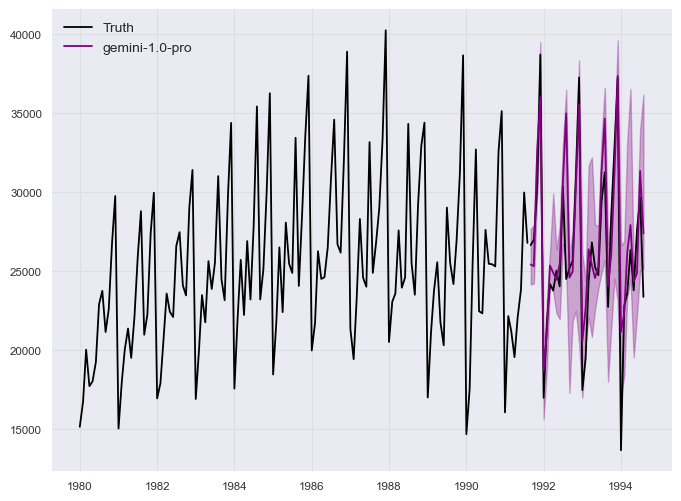

<Figure size 640x480 with 0 Axes>

In [33]:
plot_preds(train, test, out_without_blanket_2['WineDataset'], model_name='gemini-1.0-pro', ds_name='WineDataset', show_samples=False)

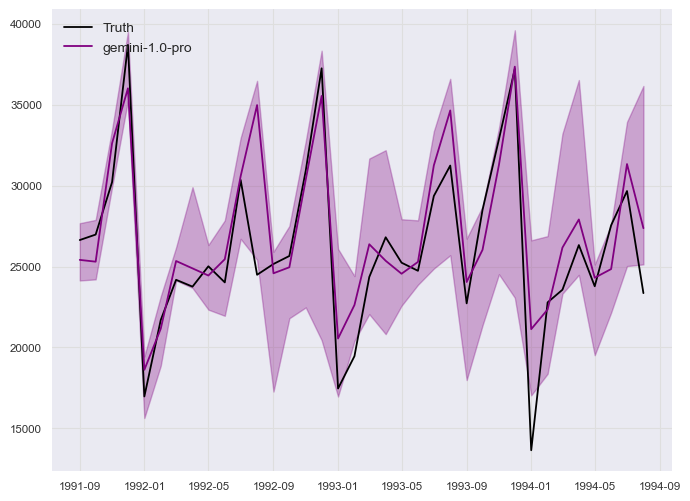

In [34]:
plot_preds2(train, test, out_without_blanket_2['WineDataset'], model_name='gemini-1.0-pro', ds_name='WineDataset', show_samples=False)

### 计算结果, 看表现如何

In [5]:
import os

from utils_paragraph import paraphrase_nlp, paraphrasing_predict_llm, paraphrase_initial, \
    paraphrase_seq2lan, recover_lan2seq, paraphrasing_predict_llama

os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai

from data1.serialize import SerializerSettings
from sklearn import metrics
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data1.small_context import get_datasets, get_memorization_datasets, get_dataset
from models.validation_likelihood_tuning import get_autotuned_predictions_data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [36]:
out_without_blanket_2['WineDataset']['samples'].iloc[0, :]

date
1991-09-01    24953.257625
1991-10-01    24898.077125
1991-11-01    33340.693625
1991-12-01    35465.142875
1992-01-01    18745.451375
1992-02-01    22414.954625
1992-03-01    23960.008625
1992-04-01    26498.311625
1992-05-01    24649.764875
1992-06-01    24787.716125
1992-07-01    32982.020375
1992-08-01    35878.996625
1992-09-01    17338.348625
1992-10-01    21835.559375
1992-11-01    23353.023125
1992-12-01    20980.261625
1993-01-01    22442.544875
1993-02-01    24180.730625
1993-03-01    30609.258875
1993-04-01    27215.658125
1993-05-01    24925.667375
1993-06-01    25118.799125
1993-07-01    33561.415625
1993-08-01    36513.572375
1993-09-01    19159.305125
1993-10-01    22552.905875
1993-11-01    24373.862375
1993-12-01    26084.457875
1994-01-01    24787.716125
1994-02-01    24980.847875
1994-03-01    33451.054625
1994-04-01    36348.030875
1994-05-01    18083.285375
1994-06-01    22028.691125
1994-07-01    23822.057375
1994-08-01    25753.374875
Freq: MS, Name: 0, dtyp

In [6]:
def metrics_used(datasets, dataset_name, originial_pred, num_samples=10):
    '''
    此为判断超参数优劣的标准
    Args:
        dataset_name: 
        originial_pred: 
        num_samples: 
    Returns:

    '''
    print("dataset_name: ", dataset_name)
    
    mse_amount = 0.0
    mae_amount = 0.0
    mape_amount = 0.0
    rsquare_amount = 0.0
    _, test = datasets[dataset_name]
    for i in range(num_samples):
        seq_pred = originial_pred[dataset_name]['samples'].iloc[i, :]
    
        mse = mean_squared_error(test, seq_pred)
        mae = mean_absolute_error(test, seq_pred)
        mape = metrics.mean_absolute_percentage_error(test, seq_pred)*100
        r2 = r2_score(test, seq_pred)
    
        mse_amount += mse
        mae_amount += mae
        mape_amount += mape
        rsquare_amount += r2
    
    mse_mean = mse_amount/num_samples
    mae_mean = mae_amount/num_samples
    mape_mean = mape_amount/num_samples
    r2_mean = rsquare_amount/num_samples
    
    # print and plot values
    print("\n")
    print('对于每次预测结果计算指标, 最后取均值')
    print(f'MSE: {mse_mean}, MAE: {mae_mean}, MAPE: {mape_mean}, R²: {r2_mean}')
    print("\n")
    
    return mse_mean, mae_mean, mape_mean, r2_mean

In [24]:
dataset_name = 'WineDataset'
num_samples = 10
metrics_used(datasets=datasets, dataset_name=dataset_name, num_samples=num_samples, originial_pred=out_without_blanket_2)

NameError: name 'out_without_blanket_2' is not defined

### 超参数寻优 (寻 temperature 和 prec), 以 MSE 为尺标,找最好的

In [25]:
model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
    # 'gemini-pro': get_llmtime_predictions_data
}
model_names = list(model_predict_fns.keys())


In [7]:
# model_predict_fns, model_names 表示使用的模型集合, 函数内有用到, 但定义在外部

def prediction_gemini(model_predict_fns, train, test, model_hypers, num_samples=10, whether_blanket=False, dataset_name='WineDataset'):
    model_names = list(model_predict_fns.keys())
    out_gemini_pro = {}  # gemini-pro
    out_gemini_pro_number = {}  # gemini-1.0-pro
    for model in model_names: 
        model_hypers[model].update({'dataset_name': dataset_name})  # for promptcast, dict 添加元素
        hypers = list(grid_iter(model_hypers[model]))  # 简单理解为传参
        # num_samples = 10  # 表示重复的预测的次数
        
        pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False, whether_blanket=whether_blanket) 
        # 这里是还未查的代码, 未确定是否一定能跑; 依据 validation likelihood 来自动 autotune hyperparameters, 原文有如此操作 (针对可训练模型更佳)
        if model == 'gemini-pro':
            out_gemini_pro.update({dataset_name: pred_dict})
        if model == 'gemini-1.0-pro':
            out_gemini_pro_number.update({dataset_name: pred_dict})
    return out_gemini_pro, out_gemini_pro_number

In [42]:
import copy
import time

# 超参数寻优
temp = [0.2, 0.4, 0.6, 0.8, 1.0]
prec = [2, 3]

# 创建一个包含序号 i 的字典的列表
gemini_hypers_list = [{f'temp': temp_val} for i, temp_val in zip(range(5), temp)]
gemini_hypers_list_tmp = copy.deepcopy(gemini_hypers_list)

for dict in gemini_hypers_list:
    dict.update({
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=2, signed=True,half_bin_correction=True)],
})
for dict in gemini_hypers_list_tmp:
    dict.update({
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
})
gemini_hypers_list.extend(gemini_hypers_list_tmp)

# 数据集
datasets = get_datasets()  # 此处为了数据集观察方便,选择了testfrac=0.4
datasets_tmp = get_memorization_datasets()  # 此处为了数据集观察方便,选择了testfrac=0.4
datasets.update(datasets_tmp)
train, test = datasets['WineDataset']  # 目前观察 WineDataset

output_metrics = []

# 预测
for index, dict in enumerate(gemini_hypers_list):
    if index > 0:
        time.sleep(60)
    model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **dict},
    # 'gemini-pro': {'model': 'gemini-pro', **dict}
}
    out_gemini_pro, out_gemini_pro_number = prediction_gemini(train, test, model_hypers, num_samples=10, whether_blanket=False)
    mse_mean, mae_mean, mape_mean, r2_mean = metrics_used(datasets=datasets, dataset_name=dataset_name, num_samples=num_samples, originial_pred=out_gemini_pro_number)
    dict.update({'mse': mse_mean, 'mae': mae_mean, 'mape': mape_mean, 'r2': r2_mean})
    output_metrics.append(dict)


D:\Desktop\Works_left_over\0-已完成 (形式上)\1-Time-LLM\2-llmtime-main\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.2, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=2, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf




  0%|          | 0/1 [00:00<?, ?it/s]

29,35,47,38,39,44,57,60,51,56,71,82,29,39,47,52,45,54,68,78,50,55,73,83,35,39,49,60,55,54,70,74,61,59,79,88,35,47,59,53,67,61,67,86,63,58,82,99,38,54,67,55,72,58,75,102,58,65,83,105,41,53,70,55,76,66,64,95,61,77,96,109,46,53,69,63,63,70,85,99,71,69,90,115,51,44,58,77,63,61,94,64,71,79,95,120,48,58,60,74,61,63,98,67,59,80,93,99,36,51,60,67,53,48,79,67,62,72,87,114,27,38,66,93,55,55,74,66,66,66,92,101,32,54,51,45,54,60,83,71,
You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence for 431.99999999999994 steps. The sequence is represented by decimal strings separated by commas, and each step consists of contents between two decimals.Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence are', just return the numbers. Sequence:
29,35,47,38,39,44,57,60,51,56,71,82,29,39,47,52,45,54,68,78,50,55,73,83,35,39,49,60,55,54,70,74,61



100%|██████████| 1/1 [04:34<00:00, 274.73s/it]

['6 5 , 6 7 , 9 5 , 1 0 9 , 4 6 , 5 3 , 6 9 , 6 3 , 6 3 , 7 0 , 8 5 , 9 9 , 7 1 , 6 9 , 9 0 , 1 1 5 , 5 1 , 4 4 , 5 8 , 7 7 , 6 3 , 6 1 , 9 4 , 6 4 , 7 1 , 7 9 , 9 5 , 1 2 0 , 4 8 , 5 8 , 6 0 , 7 4 , 6 1 , 6 3 , 9 8 , 6 7 , 5 9 , 8 0 , 9 3 , 9 9 , 3 6 , 5 1 , 6 0 , 6 7 , 5 3 , 4 8 , 7 9 , 6 7 , 6 2 , 7 2 , 8 7 , 1 1 4 , 2 7 , 3 8 , 6 6 , 9 3 , 5 5 , 5 5 , 7 4 , 6 6 , 6 6 , 6 6 , 9 2 , 1 0 1 , 3 2 , 5 4 , 5 1 , 4 5 , 5 4 , 6 0 , 8 3 , 7 1 , 6 5 , 6 7 , 9 5 , 1 0 9 , 4 6 , 5 3 , 6 9 , 6 3 , 6 3 , 7 0 , 8 5 , 9 9 , 7 1 , 6 9 , 9 0 , 1 1 5 , 5 1 , 4 4 , 5 8 , 7 7 , 6 3 , 6 1 , 9 4 , 6 4 , 7 1 , 7 9 , 9 5 , 1 2 0 , 4 8 , 5 8 , 6 0 , 7 4 , 6 1 , 6 3 , 9 8 , 6 7 , 5 9 , 8 0 , 9 3 , 9 9 , 3 6 , 5 1 , 6 0 , 6 7 , 5 3 , 4 8 , 7 9 , 6 7 , 6 2 , 7 2 , 8 7 , 1 1 4 , 2 7 , 3 8 , 6 6 , 9 3 , 5 5 , 5 5 , 7 4 , 6 6 , 6 6 , 6 6 , 9 2 , 1 0 1 , 3 2 , 5 4 , 5 1 , 4 5 , 5 4 , 6 0 , 8 3 , 7 1 , 6 5 , 6 7 , 9 5 , 1 0 9 , 4 6 , 5 3 , 6 9 , 6 3 , 6 3 , 7 0 , 8 5 , 9 9 , 7 1 , 6 9 , 9 0 , 1 1 5 , 5 1 , 4 4 , 5 

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=2, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf




  0%|          | 0/1 [00:00<?, ?it/s]

29,35,47,38,39,44,57,60,51,56,71,82,29,39,47,52,45,54,68,78,50,55,73,83,35,39,49,60,55,54,70,74,61,59,79,88,35,47,59,53,67,61,67,86,63,58,82,99,38,54,67,55,72,58,75,102,58,65,83,105,41,53,70,55,76,66,64,95,61,77,96,109,46,53,69,63,63,70,85,99,71,69,90,115,51,44,58,77,63,61,94,64,71,79,95,120,48,58,60,74,61,63,98,67,59,80,93,99,36,51,60,67,53,48,79,67,62,72,87,114,27,38,66,93,55,55,74,66,66,66,92,101,32,54,51,45,54,60,83,71,
You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence for 431.99999999999994 steps. The sequence is represented by decimal strings separated by commas, and each step consists of contents between two decimals.Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence are', just return the numbers. Sequence:
29,35,47,38,39,44,57,60,51,56,71,82,29,39,47,52,45,54,68,78,50,55,73,83,35,39,49,60,55,54,70,74,61



100%|██████████| 1/1 [04:28<00:00, 268.82s/it]

['6 8 , 6 3 , 8 8 , 1 0 0 , 3 8 , 4 4 , 5 9 , 6 7 , 5 5 , 6 2 , 8 4 , 9 3 , 3 7 , 5 2 , 6 9 , 6 3 , 6 9 , 6 6 , 8 6 , 9 4 , 6 6 , 6 2 , 8 5 , 1 0 1 , 3 9 , 4 8 , 5 8 , 7 1 , 5 9 , 6 3 , 8 9 , 9 1 , 6 9 , 6 4 , 8 7 , 1 0 3 , 4 1 , 5 3 , 6 9 , 6 3 , 6 9 , 6 6 , 8 6 , 9 4 , 6 6 , 6 2 , 8 5 , 1 0 1 , 3 9 , 4 8 , 5 8 , 7 1 , 5 9 , 6 3 , 8 9 , 9 1 , 6 9 , 6 4 , 8 7 , 1 0 3 , 4 1 , 5 3 , 6 9 , 6 3 , 6 9 , 6 6 , 8 6 , 9 4 , 6 6 , 6 2 , 8 5 , 1 0 1 , 3 9 , 4 8 , 5 8 , 7 1 , 5 9 , 6 3 , 8 9 , 9 1 , 6 9 , 6 4 , 8 7 , 1 0 3 , 4 1 , 5 3 , 6 9 , 6 3 , 6 9 , 6 6 , 8 6 , 9 4 , 6 6 , 6 2 , 8 5 , 1 0 1 , 3 9 , 4 8 , 5 8 , 7 1 , 5 9 , 6 3 , 8 9 , 9 1 , 6 9 , 6 4 , 8 7 , 1 0 3 , 4 1 , 5 3 , 6 9 , 6 3 , 6 9 , 6 6 , 8 6 , 9 4 , 6 6 , 6 2 , 8 5 , 1 0 1 , 3 9 , 4 8 , 5 8 , 7 1 , 5 9 , 6 3 , 8 9 , 9 1 , 6 9 , 6 4 , 8 7 , 1 0 3 , 4 1 , 5 3 , 6 9 , 6 3 , 6 9 , 6 6 , 8 6 , 9 4 , 6 6 , 6 2 , 8 5 , 1 0 1 , 3 9 , 4 8 , 5 8 , 7 1 , 5 9 , 6 3 , 8 9 , 9 1 , 6 9 , 6 4 , 8 7 , 1 0 3 , 4 1 , 5 3 , 6 9 , 6 3 , 6 9 , 6 6 , 

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.6, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=2, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf




  0%|          | 0/1 [00:00<?, ?it/s]

29,35,47,38,39,44,57,60,51,56,71,82,29,39,47,52,45,54,68,78,50,55,73,83,35,39,49,60,55,54,70,74,61,59,79,88,35,47,59,53,67,61,67,86,63,58,82,99,38,54,67,55,72,58,75,102,58,65,83,105,41,53,70,55,76,66,64,95,61,77,96,109,46,53,69,63,63,70,85,99,71,69,90,115,51,44,58,77,63,61,94,64,71,79,95,120,48,58,60,74,61,63,98,67,59,80,93,99,36,51,60,67,53,48,79,67,62,72,87,114,27,38,66,93,55,55,74,66,66,66,92,101,32,54,51,45,54,60,83,71,
You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence for 431.99999999999994 steps. The sequence is represented by decimal strings separated by commas, and each step consists of contents between two decimals.Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence are', just return the numbers. Sequence:
29,35,47,38,39,44,57,60,51,56,71,82,29,39,47,52,45,54,68,78,50,55,73,83,35,39,49,60,55,54,70,74,61



100%|██████████| 1/1 [04:18<00:00, 258.04s/it]

['7 0 , 6 9 , 9 3 , 1 0 8 , 3 5 , 5 6 , 6 7 , 5 2 , 7 5 , 6 8 , 8 4 , 1 0 5 , 6 6 , 6 6 , 8 9 , 1 0 4 , 4 7 , 5 1 , 6 3 , 6 6 , 6 9 , 7 9 , 9 7 , 1 1 8 , 6 7 , 7 0 , 9 6 , 1 1 6 , 4 9 , 5 4 , 6 8 , 6 0 , 7 1 , 6 1 , 8 9 , 8 2 , 6 5 , 7 3 , 9 1 , 1 0 4 , 4 1 , 4 5 , 7 2 , 6 0 , 6 9 , 6 1 , 8 9 , 9 0 , 6 2 , 7 1 , 9 1 , 1 0 4 , 3 9 , 5 2 , 7 1 , 6 1 , 7 2 , 6 1 , 9 1 , 8 0 , 6 5 , 7 1 , 9 4 , 1 1 1 , 5 1 , 5 5 , 7 1 , 6 5 , 6 4 , 7 2 , 9 2 , 8 7 , 6 0 , 7 3 , 9 3 , 1 1 0 , 4 4 , 5 4 , 7 2 , 6 7 , 7 3 , 6 1 , 9 5 , 8 9 , 6 4 , 6 7 , 9 4 , 1 1 2 , 4 3 , 5 7 , 7 8 , 5 6 , 7 5 , 6 4 , 9 5 , 8 9 , 6 3 , 7 1 , 9 2 , 1 1 3 , 4 1 , 5 3 , 7 8 , 5 3 , 7 3 , 6 6 , 9 8 , 9 8 , 6 3 , 7 3 , 9 3 , 1 1 6 , 4 3 , 5 7 , 7 8 , 5 4 , 7 6 , 6 5 , 9 7 , 9 6 , 6 5 , 7 1 , 9 3 , 1 1 5 , 4 4 , 5 5 , 7 8 , 5 6 , 7 6 , 6 1 , 9 8 , 8 9 , 6 6 , 7 3 , 9 5 , 1 1 6 , 4 5 , 5 1 , 7 9 , 5 9 , 7 3 , 6 5 , 9 9 , 9 5 , 6 3 , 7 6 , 9 7 , 1 1 7 , 4 3 , 5 7 , 7 8 , 5 9 , 7 5 , 6 3 , 1 0 1 , 9 7 , 6 4 , 7 5 , 9 7 , 1 1 8 , 4 4 

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.8, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=2, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf




  0%|          | 0/1 [00:00<?, ?it/s]

29,35,47,38,39,44,57,60,51,56,71,82,29,39,47,52,45,54,68,78,50,55,73,83,35,39,49,60,55,54,70,74,61,59,79,88,35,47,59,53,67,61,67,86,63,58,82,99,38,54,67,55,72,58,75,102,58,65,83,105,41,53,70,55,76,66,64,95,61,77,96,109,46,53,69,63,63,70,85,99,71,69,90,115,51,44,58,77,63,61,94,64,71,79,95,120,48,58,60,74,61,63,98,67,59,80,93,99,36,51,60,67,53,48,79,67,62,72,87,114,27,38,66,93,55,55,74,66,66,66,92,101,32,54,51,45,54,60,83,71,
You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence for 431.99999999999994 steps. The sequence is represented by decimal strings separated by commas, and each step consists of contents between two decimals.Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence are', just return the numbers. Sequence:
29,35,47,38,39,44,57,60,51,56,71,82,29,39,47,52,45,54,68,78,50,55,73,83,35,39,49,60,55,54,70,74,61



100%|██████████| 1/1 [03:01<00:00, 181.10s/it]

['6 6 , 7 7 , 1 0 5 , 1 0 7 , 4 4 , 4 0 , 6 1 , 5 8 , 7 3 , 5 8 , 8 0 , 7 4 , 8 3 , 7 1 , 9 0 , 8 0 , 6 6 , 7 4 , 9 1 , 8 6 , 1 0 1 , 7 4 , 7 1 , 8 0 , 8 3 , 7 2 , 7 8 , 8 8 , 8 6 , 1 0 1 , 7 7 , 7 6 , 9 1 , 8 4 , 9 2 , 8 5 , 8 8 , 8 8 , 8 3 , 7 6 , 8 2 , 7 3 , 7 6 , 8 7 , 8 7 , 8 0 , 7 8 , 8 8 , 7 8 , 8 8 , 8 6 , 8 6 , 7 8 , 8 3 , 8 8 , 8 8 , 8 3 , 8 7 , 8 3 , 8 7 , 7 9 , 8 0 , 8 5 , 8 5 , 8 2 , 8 3 , 8 6 , 8 8 , 8 0 , 8 1 , 8 5 , 8 7 , 8 8 , 8 3 , 8 7 , 8 6 , 8 7 , 8 1 , 8 3 , 8 7 , 8 7 , 8 2 , 8 6 , 8 5 , 8 5 , 8 3 , 8 7 , 8 8 , 8 6 , 8 6 , 8 3 , 8 6 , 8 8 , 8 6 , 8 6 , 8 3 , 8 6 , 8 8 , 8 5 , 8 6 , 8 3 , 8 6 , 8 8 , 8 4 , 8 5 , 8 3 , 8 6 , 8 8 , 8 4 , 8 5 , 8 3 , 8 6 , 8 8', '6 9 , 7 6 , 1 0 2 , 1 1 5 , 4 3 , 4 9 , 6 3 , 4 7 , 5 9 , 6 2 , 9 4 , 7 5 , 4 8 , 5 6 , 5 8 , 5 0 , 6 0 , 6 8 , 7 7 , 7 8 , 6 8 , 6 7 , 8 1 , 9 5 , 4 6 , 4 9 , 6 7 , 6 4 , 6 3 , 5 9 , 8 2 , 7 7 , 6 4 , 6 2 , 8 6 , 9 2 , 4 4 , 5 4 , 6 3 , 4 9 , 6 6 , 6 1 , 9 7 , 7 2 , 6 0 , 6 5 , 8 5 , 9 9 , 4 5 , 5 6 , 6 4 , 5

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 1.0, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=2, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf




  0%|          | 0/1 [00:00<?, ?it/s]

29,35,47,38,39,44,57,60,51,56,71,82,29,39,47,52,45,54,68,78,50,55,73,83,35,39,49,60,55,54,70,74,61,59,79,88,35,47,59,53,67,61,67,86,63,58,82,99,38,54,67,55,72,58,75,102,58,65,83,105,41,53,70,55,76,66,64,95,61,77,96,109,46,53,69,63,63,70,85,99,71,69,90,115,51,44,58,77,63,61,94,64,71,79,95,120,48,58,60,74,61,63,98,67,59,80,93,99,36,51,60,67,53,48,79,67,62,72,87,114,27,38,66,93,55,55,74,66,66,66,92,101,32,54,51,45,54,60,83,71,
You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence for 431.99999999999994 steps. The sequence is represented by decimal strings separated by commas, and each step consists of contents between two decimals.Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence are', just return the numbers. Sequence:
29,35,47,38,39,44,57,60,51,56,71,82,29,39,47,52,45,54,68,78,50,55,73,83,35,39,49,60,55,54,70,74,61



100%|██████████| 1/1 [01:42<00:00, 102.81s/it]

['6 7 , 5 7 , 8 4 , 9 3 , 2 4 , 4 9 , 6 2 , 4 7 , 4 9 , 6 6 , 9 6 , 7 0 , 3 6 , 4 9 , 7 1 , 6 2 , 7 4 , 5 3 , 7 2 , 8 8 , 6 5 , 3 9 , 7 2 , 1 0 8 , 2 3 , 3 4 , 5 1 , 8 3 , 4 6 , 7 4 , 4 9 , 7 4 , 9 4 , 5 8 , 5 3 , 7 4 , 1 0 0 , 1 5 , 4 2 , 5 1 , 8 1 , 5 8 , 7 1 , 4 9 , 6 4 , 1 0 3 , 5 1 , 5 0 , 7 3 , 9 8 , 2 , 4 5 , 5 0 , 6 8 , 6 8 , 6 3 , 7 4 , 8 0 , 9 6 , 6 5 , 6 5 , 1 0 5 , 2 6 , 4 4 , 4 7 , 8 2 , 5 5 , 5 7 , 7 5 , 7 4 , 1 1 2 , 6 3 , 5 6 , 9 1 , 1 6 , 5 0 , 4 9 , 6 4 , 6 7 , 5 5 , 8 2 , 7 9 , 9 5 , 7 0 , 6 3 , 8 8 , 1 3 , 4 1 , 4 4 , 7 3 , 6 5 , 7 2 , 7 0 , 6 6 , 9 6 , 7 0 , 6 2 , 8 3 , 6 , 4 5 , 5 7 , 6 4 , 4 8 , 7 5 , 8 1 , 6 1 , 1 0 6 , 4 7 , 5 5 , 8 9 , 2 2 , 4 2 , 5 2 , 6 3 , 5 9 , 5 8 , 7 0 , 7 3 , 9 7 , 5 7 , 7 3 , 8 2 , 1 1 , 2 4 , 5 0 , 7 3 , 5 5 , 4 9 , 8 5 , 7 8 , 7 9 , 5 8 , 8 0 , 7 4 , 1 7 , 3 4 , 6 9 , 7 0 , 4 3 , 6 2 , 9 7 , 9 9 , 1 0 6 , 4 1 , 6 9 , 8 6 , 9 , 3 5 , 4 5 , 8 3 , 4 4 , 6 5 , 7 8 , 8 0 , 8 2 , 5 3 , 7 0 , 9 2 , 0 , 4 6 , 4 4 , 6 7 , 6 4 , 5 6 , 7 3 , 8 

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.2, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf




  0%|          | 0/1 [00:00<?, ?it/s]

294,352,471,387,399,442,575,606,512,564,716,823,290,397,471,520,452,547,681,789,505,552,738,831,359,394,490,600,558,546,709,741,618,596,796,883,358,472,596,534,674,610,670,869,633,584,822,991,382,546,677,551,720,586,754,1029,586,656,833,1059,414,537,706,557,762,668,647,957,617,777,961,1099,469,532,697,633,637,706,859,999,713,694,908,1154,519,449,585,771,636,615,947,647,717,795,953,1204,489,581,600,745,613,637,989,670,597,800,938,992,361,511,606,672,534,481,797,670,621,723,877,1146,277,381,668,930,559,554,746,668,667,662,926,1018,327,548,514,454,546,609,832,716,
You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence for 431.99999999999994 steps. The sequence is represented by decimal strings separated by commas, and each step consists of contents between two decimals.Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence



100%|██████████| 1/1 [04:29<00:00, 269.11s/it]

['6 1 7 , 6 6 7 , 9 9 7 , 1 0 9 4 , 4 1 6 , 5 6 1 , 6 6 0 , 6 6 7 , 6 6 2 , 7 5 2 , 9 7 0 , 1 0 5 5 , 3 7 4 , 5 2 6 , 5 8 8 , 5 4 0 , 5 1 4 , 5 4 6 , 7 6 2 , 7 1 6 , 6 1 7 , 6 6 7 , 9 9 7 , 1 0 9 4 , 4 1 6 , 5 6 1 , 6 6 0 , 6 6 7 , 6 6 2 , 7 5 2 , 9 7 0 , 1 0 5 5 , 3 7 4 , 5 2 6 , 5 8 8 , 5 4 0 , 5 1 4 , 5 4 6 , 7 6 2 , 7 1 6 , 6 1 7 , 6 6 7 , 9 9 7 , 1 0 9 4 , 4 1 6 , 5 6 1 , 6 6 0 , 6 6 7 , 6 6 2 , 7 5 2 , 9 7 0 , 1 0 5 5 , 3 7 4 , 5 2 6 , 5 8 8 , 5 4 0 , 5 1 4 , 5 4 6 , 7 6 2 , 7 1 6 , 6 1 7 , 6 6 7 , 9 9 7 , 1 0 9 4 , 4 1 6 , 5 6 1 , 6 6 0 , 6 6 7 , 6 6 2 , 7 5 2 , 9 7 0 , 1 0 5 5 , 3 7 4 , 5 2 6 , 5 8 8 , 5 4 0 , 5 1 4 , 5 4 6 , 7 6 2 , 7 1 6 , 6 1 7 , 6 6 7 , 9 9 7 , 1 0 9 4 , 4 1 6 , 5 6 1 , 6 6 0 , 6 6 7 , 6 6 2 , 7 5 2 , 9 7 0 , 1 0 5 5 , 3 7 4 , 5 2 6 , 5 8 8 , 5 4 0 , 5 1 4 , 5 4 6 , 7 6 2 , 7 1 6 , 6 1 7 , 6 6 7 , 9 9 7 , 1 0 9 4 , 4 1 6 , 5 6 1 , 6 6 0 , 6 6 7 , 6 6 2 , 7 5 2 , 9 7 0 , 1 0 5 5 , 3 7 4 , 5 2 6 , 5 8 8 , 5 4 0 , 5 1 4 , 5 4 6 , 7 6 2 , 7 1 6 , 6 1 7 , 6 6 7 

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf




  0%|          | 0/1 [00:00<?, ?it/s]

294,352,471,387,399,442,575,606,512,564,716,823,290,397,471,520,452,547,681,789,505,552,738,831,359,394,490,600,558,546,709,741,618,596,796,883,358,472,596,534,674,610,670,869,633,584,822,991,382,546,677,551,720,586,754,1029,586,656,833,1059,414,537,706,557,762,668,647,957,617,777,961,1099,469,532,697,633,637,706,859,999,713,694,908,1154,519,449,585,771,636,615,947,647,717,795,953,1204,489,581,600,745,613,637,989,670,597,800,938,992,361,511,606,672,534,481,797,670,621,723,877,1146,277,381,668,930,559,554,746,668,667,662,926,1018,327,548,514,454,546,609,832,716,
You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence for 431.99999999999994 steps. The sequence is represented by decimal strings separated by commas, and each step consists of contents between two decimals.Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence



100%|██████████| 1/1 [04:14<00:00, 254.07s/it]

['7 3 2 , 6 9 5 , 8 3 3 , 1 0 5 9 , 4 1 4 , 5 3 7 , 7 0 6 , 5 5 7 , 7 6 2 , 6 6 8 , 6 4 7 , 9 5 7 , 6 1 7 , 7 7 7 , 9 6 1 , 1 0 9 9 , 4 6 9 , 5 3 2 , 6 9 7 , 6 3 3 , 6 3 7 , 7 0 6 , 8 5 9 , 9 9 9 , 7 1 3 , 6 9 4 , 9 0 8 , 1 1 5 4 , 5 1 9 , 4 4 9 , 5 8 5 , 7 7 1 , 6 3 6 , 6 1 5 , 9 4 7 , 6 4 7 , 7 1 7 , 7 9 5 , 9 5 3 , 1 2 0 4 , 4 8 9 , 5 8 1 , 6 0 0 , 7 4 5 , 6 1 3 , 6 3 7 , 9 8 9 , 6 7 0 , 5 9 7 , 8 0 0 , 9 3 8 , 9 9 2 , 3 6 1 , 5 1 1 , 6 0 6 , 6 7 2 , 5 3 4 , 4 8 1 , 7 9 7 , 6 7 0 , 6 2 1 , 7 2 3 , 8 7 7 , 1 1 4 6 , 2 7 7 , 3 8 1 , 6 6 8 , 9 3 0 , 5 5 9 , 5 5 4 , 7 4 6 , 6 6 8 , 6 6 7 , 6 6 2 , 9 2 6 , 1 0 1 8 , 3 2 7 , 5 4 8 , 5 1 4 , 4 5 4 , 5 4 6 , 6 0 9 , 8 3 2 , 7 1 6 , 7 3 2 , 6 9 5 , 8 3 3 , 1 0 5 9 , 4 1 4 , 5 3 7 , 7 0 6 , 5 5 7 , 7 6 2 , 6 6 8 , 6 4 7 , 9 5 7 , 6 1 7 , 7 7 7 , 9 6 1 , 1 0 9 9 , 4 6 9 , 5 3 2 , 6 9 7 , 6 3 3 , 6 3 7 , 7 0 6 , 8 5 9 , 9 9 9 , 7 1 3 , 6 9 4 , 9 0 8 , 1 1 5 4 , 5 1 9 , 4 4 9 , 5 8 5 , 7 7 1 , 6 3 6 , 6 1 5 , 9 4 7 , 6 4 7 , 7 1 7 , 7 9 5 , 9 5 

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.6, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf




  0%|          | 0/1 [00:00<?, ?it/s]

294,352,471,387,399,442,575,606,512,564,716,823,290,397,471,520,452,547,681,789,505,552,738,831,359,394,490,600,558,546,709,741,618,596,796,883,358,472,596,534,674,610,670,869,633,584,822,991,382,546,677,551,720,586,754,1029,586,656,833,1059,414,537,706,557,762,668,647,957,617,777,961,1099,469,532,697,633,637,706,859,999,713,694,908,1154,519,449,585,771,636,615,947,647,717,795,953,1204,489,581,600,745,613,637,989,670,597,800,938,992,361,511,606,672,534,481,797,670,621,723,877,1146,277,381,668,930,559,554,746,668,667,662,926,1018,327,548,514,454,546,609,832,716,
You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence for 431.99999999999994 steps. The sequence is represented by decimal strings separated by commas, and each step consists of contents between two decimals.Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence



100%|██████████| 1/1 [04:10<00:00, 250.02s/it]

['7 3 9 , 7 2 7 , 8 4 9 , 9 7 7 , 3 2 4 , 4 1 8 , 6 2 0 , 7 3 3 , 5 9 7 , 5 1 9 , 7 3 5 , 8 7 2 , 3 0 0 , 4 5 8 , 5 6 6 , 5 4 0 , 6 0 3 , 5 9 8 , 7 9 1 , 9 0 6 , 5 7 2 , 5 8 2 , 7 8 0 , 8 7 9 , 3 2 2 , 4 2 9 , 5 5 7 , 6 2 9 , 5 4 6 , 5 6 8 , 7 2 5 , 7 4 6 , 6 6 1 , 6 3 3 , 8 3 5 , 9 0 2 , 3 3 5 , 5 3 3 , 6 3 1 , 5 4 1 , 6 6 6 , 6 2 5 , 6 7 0 , 8 7 8 , 6 5 9 , 6 2 0 , 8 4 3 , 9 1 8 , 3 5 7 , 5 8 1 , 6 9 8 , 5 5 4 , 7 3 5 , 6 0 6 , 7 6 2 , 1 0 4 7 , 6 1 0 , 6 7 0 , 8 5 0 , 1 0 7 6 , 4 3 0 , 5 5 4 , 7 2 3 , 5 6 5 , 7 7 0 , 6 8 5 , 6 6 4 , 9 7 4 , 6 3 5 , 7 9 4 , 9 7 8 , 1 1 1 6 , 4 8 5 , 5 4 9 , 7 1 4 , 6 5 0 , 6 5 4 , 7 2 3 , 8 7 6 , 1 0 1 5 , 7 3 0 , 7 1 1 , 9 2 5 , 1 1 7 1 , 5 3 5 , 4 6 5 , 6 0 1 , 7 8 7 , 6 5 2 , 6 3 3 , 9 6 5 , 6 6 4 , 7 3 4 , 8 1 2 , 9 7 0 , 1 2 2 2 , 5 0 5 , 6 0 0 , 6 1 9 , 7 6 3 , 6 2 9 , 6 5 4 , 1 0 0 6 , 6 8 7 , 6 1 4 , 8 1 7 , 9 5 5 , 9 9 9 , 3 7 8 , 5 2 8 , 6 2 4 , 6 9 0 , 5 5 2 , 5 0 9 , 8 1 5 , 6 8 7 , 6 3 8 , 7 4 0 , 8 9 4 , 1 1 6 3 , 2 9 5 , 4 0 9 , 6 9 6 

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.8, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf




  0%|          | 0/1 [00:00<?, ?it/s]

294,352,471,387,399,442,575,606,512,564,716,823,290,397,471,520,452,547,681,789,505,552,738,831,359,394,490,600,558,546,709,741,618,596,796,883,358,472,596,534,674,610,670,869,633,584,822,991,382,546,677,551,720,586,754,1029,586,656,833,1059,414,537,706,557,762,668,647,957,617,777,961,1099,469,532,697,633,637,706,859,999,713,694,908,1154,519,449,585,771,636,615,947,647,717,795,953,1204,489,581,600,745,613,637,989,670,597,800,938,992,361,511,606,672,534,481,797,670,621,723,877,1146,277,381,668,930,559,554,746,668,667,662,926,1018,327,548,514,454,546,609,832,716,
You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence for 431.99999999999994 steps. The sequence is represented by decimal strings separated by commas, and each step consists of contents between two decimals.Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence



100%|██████████| 1/1 [02:53<00:00, 173.78s/it]

['8 7 7 , 6 1 8 , 6 2 6 , 8 3 7 , 1 0 5 2 , 3 8 0 , 5 4 0 , 6 0 3 , 6 0 4 , 6 7 6 , 7 5 3 , 6 3 2 , 7 0 6 , 8 6 0 , 9 9 1 , 6 3 2 , 7 0 9 , 8 6 9 , 1 0 1 8 , 3 7 3 , 5 8 1 , 6 0 6 , 7 0 7 , 5 7 2 , 6 2 8 , 8 6 4 , 1 0 2 0 , 6 6 4 , 6 6 6 , 8 6 4 , 1 0 5 2 , 3 8 8 , 4 8 1 , 6 8 4 , 7 2 7 , 6 4 4 , 5 1 4 , 7 7 3 , 6 7 2 , 6 2 1 , 7 3 9 , 8 8 3 , 1 1 6 0 , 3 4 7 , 5 0 9 , 6 0 3 , 6 5 5 , 6 1 1 , 5 5 7 , 7 8 5 , 6 8 9 , 6 2 4 , 7 4 0 , 9 2 8 , 1 0 0 6 , 4 0 1 , 5 0 5 , 5 8 7 , 6 7 6 , 6 1 0 , 6 3 1 , 8 7 9 , 6 9 4 , 5 7 8 , 7 5 9 , 9 0 5 , 1 1 9 5 , 3 3 1 , 4 6 6 , 5 1 9 , 6 7 2 , 5 7 2 , 5 3 3 , 8 3 1 , 7 3 6 , 5 9 1 , 7 3 8 , 9 4 4 , 1 0 2 1 , 4 0 2 , 5 3 4 , 6 0 1 , 6 5 9 , 5 3 2 , 5 4 0 , 7 8 7 , 6 7 6 , 6 2 5 , 7 4 1 , 9 0 7 , 1 1 6 9 , 3 1 7 , 5 0 0 , 5 9 1 , 6 6 4 , 5 5 1 , 5 2 4 , 8 0 9 , 7 2 2 , 5 5 6 , 7 2 7 , 8 9 7 , 1 1 6 2 , 2 8 2 , 4 3 4 , 5 6 9 , 6 7 9 , 5 7 9 , 5 4 7 , 7 8 1 , 6 9 1 , 6 1 9 , 7 3 6 , 9 2 7 , 9 9 6 , 3 5 4 , 5 1 3 , 6 1 7 , 6 5 5 , 5 4 8 , 5 4 5 , 8 3 3 , 6 

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 1.0, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf




  0%|          | 0/1 [00:00<?, ?it/s]

294,352,471,387,399,442,575,606,512,564,716,823,290,397,471,520,452,547,681,789,505,552,738,831,359,394,490,600,558,546,709,741,618,596,796,883,358,472,596,534,674,610,670,869,633,584,822,991,382,546,677,551,720,586,754,1029,586,656,833,1059,414,537,706,557,762,668,647,957,617,777,961,1099,469,532,697,633,637,706,859,999,713,694,908,1154,519,449,585,771,636,615,947,647,717,795,953,1204,489,581,600,745,613,637,989,670,597,800,938,992,361,511,606,672,534,481,797,670,621,723,877,1146,277,381,668,930,559,554,746,668,667,662,926,1018,327,548,514,454,546,609,832,716,
You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence for 431.99999999999994 steps. The sequence is represented by decimal strings separated by commas, and each step consists of contents between two decimals.Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence



100%|██████████| 1/1 [01:28<00:00, 88.01s/it]

['7 4 0 , 6 7 7 , 7 0 0 , 9 2 1 , 9 6 4 , 6 7 6 , 5 9 6 , 9 6 7 , 1 0 9 9 , 5 3 2 , 6 0 9 , 6 0 0 , 5 4 3 , 6 1 7 , 5 4 2 , 8 9 4 , 6 7 3 , 6 7 9 , 8 9 1 , 9 6 8 , 5 5 6 , 5 8 2 , 7 3 4 , 7 4 0 , 6 8 3 , 6 4 3 , 9 0 7 , 6 5 3 , 7 8 1 , 8 5 7 , 1 1 0 6 , 2 2 3 , 5 0 4 , 6 0 8 , 6 6 4 , 6 2 6 , 6 1 7 , 8 8 6 , 6 9 6 , 5 1 3 , 7 9 5 , 8 4 4 , 1 0 9 0 , 2 5 8 , 4 3 2 , 6 1 2 , 7 1 0 , 9 2 2 , 5 0 9 , 7 0 2 , 9 6 0 , 5 4 6 , 6 1 6 , 8 6 7 , 1 1 1 9 , 3 0 9 , 4 4 3 , 6 3 8 , 7 4 5 , 6 9 7 , 5 7 8 , 8 3 6 , 7 2 0 , 6 0 0 , 7 8 9 , 1 0 4 2 , 1 0 0 9 , 4 6 2 , 5 7 5 , 6 4 8 , 5 7 5 , 6 8 3 , 6 7 3 , 9 0 5 , 7 2 0 , 6 2 1 , 8 7 4 , 1 1 5 7 , 4 2 4', '5 9 2 , 9 8 3 , 7 0 8 , 7 3 1 , 6 4 3 , 6 4 4 , 9 3 4 , 8 5 8 , 7 4 9 , 7 2 0 , 1 0 9 4 , 9 4 6 , 5 4 0 , 4 8 0 , 4 9 2 , 6 3 7 , 6 0 1 , 7 3 6 , 7 0 2 , 7 9 6 , 8 7 1 , 7 5 9 , 8 0 8 , 7 8 6 , 6 8 4 , 6 7 2 , 6 1 7 , 5 6 1 , 4 2 5 , 6 3 9 , 9 0 0 , 7 6 4 , 6 8 2 , 6 2 7 , 6 6 8 , 9 6 2 , 6 0 2 , 6 4 3 , 4 6 2 , 6 4 3 , 6 4 1 , 7 8 6', '7 9 3 , 6 2 

In [43]:
mape_list = []
r2_list = []
for dict in output_metrics:
    mape_list.append(dict['mape'])
    r2_list.append(dict['r2'])

def find_minimum_index(lst):
    min_value = min(lst)
    min_index = lst.index(min_value)
    return min_index

def find_maximum_index(lst):
    max_value = max(lst)
    max_index = lst.index(max_value)
    return max_index

argmin_mape = find_minimum_index(mape_list)
argmin_r2 = find_maximum_index(r2_list)

gemini_hypers_list[argmin_mape]
# 对于mape和r2而言, 最优组合都是 'temp': 0.2, prec=3; 此时指标有:
# 'mse': 18486572.298571058,
#  'mae': 3054.512945833332,
#  'mape': 12.519014054896632,
#  'r2': 0.3412917235847458}

{'temp': 0.4,
 'alpha': 0.95,
 'beta': 0.3,
 'basic': [False],
 'settings': [SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan')],
 'mse': 24100678.72906979,
 'mae': 3431.5938069444433,
 'mape': 13.889227990410399,
 'r2': 0.14125148298635942}

In [44]:
print(gemini_hypers_list[argmin_mape], gemini_hypers_list[argmin_r2])
# temp 不稳定，可能 0.2 or 0.4 都可 (注意是较小的值即可）


{'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': [False], 'settings': [SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan')], 'mse': 24100678.72906979, 'mae': 3431.5938069444433, 'mape': 13.889227990410399, 'r2': 0.14125148298635942} {'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': [False], 'settings': [SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan')], 'mse': 24100678.72906979, 'mae': 3431.5938069444433, 'mape': 13.889227990410399, 'r2': 0.14125148298635942}


### 周期预测

In [88]:
# # test_len = len(test)
# # steps = test_len*10
# 
# # 使用 in-context learning 看看
# 
# gemini_sys_message = "You are a helpful assistant that performs time series predictions. The user will provide a sequence, and you will obtain the period of the sequence. The sequence is represented by decimal strings separated by commas. For instance, the sequence is: " + '294,352,471,387,399,442,575,606,512,564,716,823,290,397,471,520,452,547,681,789,505,552,738,831,359,394,490,600,558,546,709,741,618,596,796,883,358,472,596,534,674,610,670,869,633,584,822,991,382,546,677,551,720,586,754,1029,586,656,833,1059,414,537,706,557,762,668,647,957,617,777,961,1099,469,532,697,633,637,706,859,999,713,694,908,1154,519,449,585,771,636,615,947,647,717,795,953,1204,489,581,600,745,613,637,989,670,597,800,938,992,361,511,606,672,534,481,797,670,621,723,877,1146,277,381,668,930,559,554,746,668,667,662,926,1018,327,548,514,454,546,609,832,716,' + 'and the period of the sequence is 12.'
# extra_input = "Please predict the period without producing any additional text. Do not say anything like 'the period is', just return the number. Sequence:\n"
# 
# 
# # . Note that the sequence is constructed by several time series components including the trend components, seasonal components and irregular components,

# 根据代码里加 print, 强行拉出来了....没有改动代码, 这是一个偷懒的做法
# 这是 prec=2 的 input_str
# input_str = '29,35,47,38,39,44,57,60,51,56,71,82,29,39,47,52,45,54,68,78,50,55,73,83,35,39,49,60,55,54,70,74,61,59,79,88,35,47,59,53,67,61,67,86,63,58,82,99,38,54,67,55,72,58,75,102,58,65,83,105,41,53,70,55,76,66,64,95,61,77,96,109,46,53,69,63,63,70,85,99,71,69,90,115,51,44,58,77,63,61,94,64,71,79,95,120,48,58,60,74,61,63,98,67,59,80,93,99,36,51,60,67,53,48,79,67,62,72,87,114,27,38,66,93,55,55,74,66,66,66,92,101,32,54,51,45,54,60,83,71,'
# 这是 prec=3 的 input_str



In [54]:
# input_str = '294,352,471,387,399,442,575,606,512,564,716,823,290,397,471,520,452,547,681,789,505,552,738,831,359,394,490,600,558,546,709,741,618,596,796,883,358,472,596,534,674,610,670,869,633,584,822,991,382,546,677,551,720,586,754,1029,586,656,833,1059,414,537,706,557,762,668,647,957,617,777,961,1099,469,532,697,633,637,706,859,999,713,694,908,1154,519,449,585,771,636,615,947,647,717,795,953,1204,489,581,600,745,613,637,989,670,597,800,938,992,361,511,606,672,534,481,797,670,621,723,877,1146,277,381,668,930,559,554,746,668,667,662,926,1018,327,548,514,454,546,609,832,716,'
# 
# # if model in ['gemini-1.0-pro', 'gemini-pro']:  # 此处为主要修改位置
# model = 'gemini-1.0-pro'
# content_fin = []
# # print(gemini_sys_message+extra_input+input_str)
# model = genai.GenerativeModel(model)
# num_samples = 5
# 
# for i in range(num_samples):
#     print("Index:", i)
#     response = model.generate_content(
#         contents=gemini_sys_message+extra_input+input_str,  # 此处因为只有一个 contents 选项, 所以将所有的话语都放在一起
#         generation_config=genai.types.GenerationConfig(
#             temperature=0.8,
#         )
#     )
#     tmp = response.text
#     content_fin.append(tmp)
# 
# # 废除

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4


In [55]:
# content_fin

['12', '12', '12', '12', '12']

In [213]:
# # 只是为了得到 input_str 的临时代码
# 
# # 模型设定
# gemini_hypers = {
#     # temp=[0.2, 0.4, 0.6, 0.8, 1.0],
#     'temp': 0.4,
#     'alpha': 0.95,
#     'beta': 0.3,
#     'basic': [False],
#     'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
#     # prec可能=3
# }
# 
# model_hypers = {
#     'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
#     # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
# }
# 
# model_predict_fns = {
#     'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
#     # 'gemini-pro': get_llmtime_predictions_data
# }
# 
# model_names = list(model_predict_fns.keys())
# datasets = get_datasets()  # 此处为了数据集观察方便,选择了testfrac=0.4
# datasets_tmp = get_memorization_datasets()  # 此处为了数据集观察方便,选择了testfrac=0.4
# datasets.update(datasets_tmp)
# 
# out_gemini_pro = {}  # gemini-pro
# out_gemini_pro_number = {}  # gemini-1.0-pro
# 
# train, test = datasets['TurkeyPower']
# for model in model_names: 
#     model_hypers[model].update({'dataset_name': 'TurkeyPower'})  # for promptcast, dict 添加元素
#     hypers = list(grid_iter(model_hypers[model]))  # 简单理解为传参
#     num_samples = 1  # 表示重复的预测的次数, 此处只是为了得到 prec
# 
#     pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False, whether_blanket=False) 
#     # 这里是还未查的代码, 未确定是否一定能跑; 依据 validation likelihood 来自动 autotune hyperparameters, 原文有如此操作 (针对可训练模型更佳)
#     if model == 'gemini-pro':
#         out_gemini_pro.update({'TurkeyPower': pred_dict})
#     if model == 'gemini-1.0-pro':
#         out_gemini_pro_number.update({'TurkeyPower': pred_dict})


D:\Desktop\Works_left_over\0-已完成 (形式上)\1-Time-LLM\2-llmtime-main\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'TurkeyPower'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

624,870,883,878,862,889,773,653,945,958,1000,999,918,805,657,936,1026,979,956,986,888,731,855,844,809,839,840,815,709,934,961,933,954,910,699,571,860,946,921,867,768,646,576,873,822,792,802,840,681,528,776,823,813,912,885,711,606,888,915,950,890,836,730,604,862,865,879,883,849,736,608,876,840,877,902,907,773,609,878,885,875,836,780,672,453,712,762,690,732,657,565,451,696,744,689,768,706,585,460,804,755,734,719,705,627,607,783,810,734,745,724,589,512,728,751,744,738,724,621,367,239,295,354,600,615,564,430,699,677,721,700,708,658,524,716,723,720,647,671,597,509,735,744,770,803,815,716,581,845,851,852,860,835,732,579,837,825,809,813,821,703,524,813,832,812,816,809,716,556,839,826,866,879,862,735,565,860,869,866,896,897,776,600,878,887,895,875,547,379,397,446,491,688,708,681,696,631,935,927,930,942,941,831,666,951,1000,999,1007,1014,881,723,1022,1020,1028,1039,1032,902,718,1018,1024,1024,994,991,868,706,936,970,983,1023,1012,878,726,1038,1023,991,958,940,823,671,923,854,973,980,986,834,653

KeyboardInterrupt: 

In [14]:
# 一般的不行, in-context learning 不行，怀疑是没表达清楚意思
# 这里很明显和 12，365，7 挂钩了 (怀疑默认了相关周，年 or 月信息）

message = ("You are a helpful assistant that specializing in time series analysis. The user will provide a sequence. The sequence is represented by decimal strings separated by commas. You need to infer the most probable underlying cycle of the sequence, even though there may also be a trend in this sequence. Do not assume that the underlying cycle has to stick to the popular cycles like 7 (days in a week), 12 (months in a year) and 30 (days in a month), just infer the cycle fully based on the inherent cycle of the given sequence. The underlying cycle of the sequence is strictly below 14. Please infer the cycle without producing any additional text. Do not say anything like 'the underlying cycle is', just return the number. Sequence:\n")

# (most probable period that can be the best to fit the seasonal pattern)
# You should infer the value of the period that is strictly below 13.
# Although there are trends and irregular components in this time series, there is also an underlying seasonal component of the sequence. 
# question_message_2 = "\n Q: You are a helpful assistant that performs time series predictions. The user will provide a sequence, and you will obtain the period of the sequence. The sequence is represented by decimal strings separated by commas. Please predict the period without producing any additional text. Do not say anything like 'the period is', just return the number. Sequence:\n"


In [15]:
safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_NONE"
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_NONE"
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_NONE"
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_NONE"
  },
]

In [18]:
# 尝试多个数据集看看
# train, test = datasets['AusBeerDataset']  # period = 4
# 无法识别 (这个差别太大了), 说到底周期不是时间序列客观存在的，而是人为赋予的概念 (known before)
# 放弃吧...... 人间美好...... (那部分感觉可以从原文里删掉.......

# Ausbeer: period = 4
# input_str = ',402,249,279,453,354,281,298,479,376,292,300,464,352,279,328,466,406,279,350,460,425,292,343,520,391,328,371,535,423,339,389,572,464,378,436,587,503,410,449,621,511,410,453,655,550,470,490,662,636,477,494,742,615,505,567,750,623,559,595,793,673,587,606,838,692,604,636,879,776,623,709,1006,791,748,759,987,866,763,726,983,888,722,765,970,836,765,774,1008,899,789,718,1056,873,744,754,985,894,709,808,922,970,737,800,1028,851,722,823,1030,813,662,726,942,765,716,688,978,789,688,701,983,778,711,714,940,825,686,737,948,810,737,752,1077,795,735,750,1011,834,739,714,1079,789,703,729,1026,744,673,694,935,722,696,673,892,757,610,701,933,707,668,686,909,671,647,647,881,720,647,664,922,'

# Wine: period = 12
# input_str = ',294,352,471,387,399,442,575,606,512,564,716,823,290,397,471,520,452,547,681,789,505,552,738,831,359,394,490,600,558,546,709,741,618,596,796,883,358,472,596,534,674,610,670,869,633,584,822,991,382,546,677,551,720,586,754,1029,586,656,833,1059,414,537,706,557,762,668,647,957,617,777,961,1099,469,532,697,633,637,706,859,999,713,694,908,1154,519,449,585,771,636,615,947,647,717,795,953,1204,489,581,600,745,613,637,989,670,597,800,938,992,361,511,606,672,534,481,797,670,621,723,877,1146,277,381,668,930,559,554,746,668,667,662,926,1018,327,548,514,454,546,609,832,716,'

# TurkeyPower: period = 7
input_str = ',624,870,883,878,862,889,773,653,945,958,1000,999,918,805,657,936,1026,979,956,986,888,731,855,844,809,839,840,815,709,934,961,933,954,910,699,571,860,946,921,867,768,646,576,873,822,792,802,840,681,528,776,823,813,912,885,711,606,888,915,950,890,836,730,604,862,865,879,883,849,736,608,876,840,877,902,907,773,609,878,885,875,836,780,672,453,712,762,690,732,657,565,451,696,744,689,768,706,585,460,804,755,734,719,705,627,607,783,810,734,745,724,589,512,728,751,744,738,724,621,367,239,295,354,600,615,564,430,699,677,721,700,708,658,524,716,723,720,647,671,597,509,735,744,770,803,815,716,581,845,851,852,860,835,732,579,837,825,809,813,821,703,524,813,832,812,816,809,716,556,839,826,866,879,862,735,565,860,869,866,896,897,776,600,878,887,895,875,547,379,397,446,491,688,708,681,696,631,935,927,930,942,941,831,666,951,1000,999,1007,1014,881,723,1022,1020,1028,1039,1032,902,718,1018,1024,1024,994,991,868,706,936,970,983,1023,1012,878,726,1038,1023,991,958,940,823,671,923,854,973,980,986,834,653,914,858,847,848,849,748,619,861,834,804,816,847,743,579,827,823,803,776,736,633,461,724,760,781,800,814,671,546,758,765,753,753,765,658,476,718,713,745,724,738,647,513,740,732,722,728,698,584,458,685,680,705,717,607,499,441,713,693,703,706,707,596,491,766,748,743,729,728,613,468,740,749,780,788,787,640,540,769,741,769,801,830,701,562,836,823,823,808'
# 加上 , 似乎稍微好点点...... (但还是要优先限制范围，不然会莫名的非常大......)

# if model in ['gemini-1.0-pro', 'gemini-pro']:  # 此处为主要修改位置
model = 'gemini-pro'
content_fin = []
# print(gemini_sys_message+extra_input+input_str)
model = genai.GenerativeModel(model)
num_samples = 20

for i in range(num_samples):
    print("Index:", i)
    response = model.generate_content(
        contents=message+input_str,  # 此处因为只有一个 contents 选项, 所以将所有的话语都放在一起
        generation_config=genai.types.GenerationConfig(
            temperature=0.4,
        ),
        safety_settings=safety_settings
    )
    tmp = response.text
    content_fin.append(tmp)


Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


TooManyRequests: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).

In [17]:
print(content_fin)

['7', '14', '12', '13', '14', '14', '14', '14', '14', '11', '6', '7', '10', '14', '7']


### 序列长度对于预测效果的影响

##### WineDataset

In [37]:
import time

# 模型设定
gemini_hypers = {
    'temp': 0.4,
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
    # 'gemini-pro': get_llmtime_predictions_data
}

model_names = list(model_predict_fns.keys())
datasets = get_datasets()  
datasets_tmp = get_memorization_datasets()  
datasets.update(datasets_tmp)

out_gemini_pro = {}  # gemini-pro
out_gemini_pro_number = {}  # gemini-1.0-pro

train, test = datasets['WineDataset']
dataset_name = 'WineDataset'

D:\Desktop\Works_left_over\0-已完成 (形式上)\1-Time-LLM\2-llmtime-main\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


In [8]:
def fig_length(metric, metric_name='R^2', dataset_name='WineDataset'):
    font_path = fm.findfont(fm.FontProperties(family='Times New Roman'))
    font_prop = fm.FontProperties(fname=font_path)
    _font_size = 38
    sns.set_style('whitegrid')
    sns.set(style="whitegrid", rc={"axes.grid.axis": "y", "axes.grid": True})
    fig = plt.figure(figsize=(12,8))
    ax1 = plt.gca()
    x = np.arange(len(metric))
    sns.lineplot(x=x, y=metric, color='#d37981', alpha=1, linewidth=5, marker='o',markerfacecolor='w',markeredgecolor='#d37981', markersize=6)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    plt.xlabel("Index", fontproperties=font_prop, fontsize=_font_size+5)
    plt.ylabel(metric_name, fontproperties=font_prop, fontsize=_font_size+5)
    plt.legend(bbox_to_anchor=(0.5, 1.4), loc='upper center',fontsize=_font_size)
    plt.tight_layout()
    plt.savefig(f"Length_of_Training_Set Analysis_0407_{dataset_name}.png")
    plt.show()

In [39]:
n = 1  # 表示减少的周期长度数
period = 12
all_rounds = int(len(train)/period)

output_ = []  # 记录是否有该现象

for index in range(0, all_rounds):  # WineDataset 来做预测, 12 是其真实 (提前给定的) 周期
    print('Round:', index)
    train_tmp = copy.deepcopy(train)
    test_tmp = copy.deepcopy(test)
    train_tmp = train_tmp.iloc[(index*period):]
    if index > 0:
        time.sleep(60)
    for model in model_names: 
        model_hypers[model].update({'dataset_name': 'WineDataset'})  # for promptcast, dict 添加元素
        hypers = list(grid_iter(model_hypers[model]))  # 简单理解为传参
        num_samples = 10  # 表示重复的预测的次数, 此处只是为了得到 prec
        out_gemini_pro, out_gemini_pro_number = prediction_gemini(train_tmp, test_tmp, model_hypers, num_samples=10, whether_blanket=False)

    mse_amount = 0.0
    mae_amount = 0.0
    mape_amount = 0.0
    rsquare_amount = 0.0
    for i in range(num_samples):
        seq_pred = out_gemini_pro_number[dataset_name]['samples'].iloc[i, :]
    
        mse = mean_squared_error(test_tmp, seq_pred)
        mae = mean_absolute_error(test_tmp, seq_pred)
        mape = metrics.mean_absolute_percentage_error(test_tmp, seq_pred)*100
        r2 = r2_score(test_tmp, seq_pred)
    
        mse_amount += mse
        mae_amount += mae
        mape_amount += mape
        rsquare_amount += r2
    
    mse_mean = mse_amount/num_samples
    mae_mean = mae_amount/num_samples
    mape_mean = mape_amount/num_samples
    r2_mean = rsquare_amount/num_samples
    
    # print and plot values
    print("\n")
    print('round:', index)
    print(f'MSE: {mse_mean}, MAE: {mae_mean}, MAPE: {mape_mean}, R²: {r2_mean}')
    print("\n")
    
    output_.append({'index': index, 'mse': mse_mean, 'mae': mae_mean, 'mape': mape_mean, 'r2': r2_mean})

Round: 0
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [04:28<00:00, 268.38s/it]




round: 0
MSE: 30810252.002162296, MAE: 4001.2485618055543, MAPE: 16.007902269883296, R²: -0.09782211999531633


Round: 1
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [04:27<00:00, 267.84s/it]




round: 1
MSE: 37317126.96068605, MAE: 4614.857442222221, MAPE: 18.39456637489743, R²: -0.329673234390929


Round: 2
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [02:52<00:00, 172.93s/it]




round: 2
MSE: 37733793.320936725, MAE: 4458.533888333333, MAPE: 17.857090790247327, R²: -0.344519771410783


Round: 3
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [03:22<00:00, 202.20s/it]




round: 3
MSE: 39455776.41039505, MAE: 4306.81486388889, MAPE: 18.26805132092962, R²: -0.4058769821772688


Round: 4
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [03:08<00:00, 188.18s/it]




round: 4
MSE: 30881590.030908465, MAE: 3740.0556477777777, MAPE: 15.71828696696671, R²: -0.10036401630791059


Round: 5
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [02:16<00:00, 136.40s/it]




round: 5
MSE: 39824582.7179998, MAE: 4337.898729166667, MAPE: 18.70453389250694, R²: -0.4190181834389099


Round: 6
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [02:06<00:00, 126.95s/it]




round: 6
MSE: 56656979.87369182, MAE: 5652.386813611112, MAPE: 23.798216019895584, R²: -1.0187853625183947


Round: 7
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [02:33<00:00, 153.70s/it]




round: 7
MSE: 40789281.32863949, MAE: 4743.844314583334, MAPE: 19.974878485656657, R²: -0.4533920494434679


Round: 8
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [02:45<00:00, 165.55s/it]




round: 8
MSE: 51232159.25469852, MAE: 5379.249963611111, MAPE: 21.163218475206442, R²: -0.8254897000187971


Round: 9
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [03:38<00:00, 218.65s/it]




round: 9
MSE: 122884289.39341688, MAE: 6448.703378055556, MAPE: 26.026067703447943, R²: -3.3785779839298646


Round: 10
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [04:02<00:00, 242.22s/it]



round: 10
MSE: 43331427.37209271, MAE: 5069.289409722222, MAPE: 20.771333587930037, R²: -0.5439730728822134


In [40]:
out_gemini_pro_number['WineDataset']['samples']

date,1991-09-01,1991-10-01,1991-11-01,1991-12-01,1992-01-01,1992-02-01,1992-03-01,1992-04-01,1992-05-01,1992-06-01,...,1993-11-01,1993-12-01,1994-01-01,1994-02-01,1994-03-01,1994-04-01,1994-05-01,1994-06-01,1994-07-01,1994-08-01
0,30705.535625,27648.303125,28085.050625,27260.083125,23766.103125,25367.510625,27405.665625,31481.975625,26944.654375,26847.599375,...,30001.886875,30171.733125,30365.843125,28036.523125,26968.918125,25464.565625,25391.774375,25755.730625,26750.544375,28643.116875
1,30341.579375,27526.984375,32379.734375,27624.039375,19544.210625,22237.486875,22188.959375,22188.959375,22188.959375,22188.959375,...,22188.959375,22188.959375,22188.959375,22188.959375,22188.959375,22188.959375,22188.959375,22188.959375,22188.959375,22188.959375
2,21266.936875,32185.624375,32452.525625,28934.281875,32403.998125,31190.810625,30438.634375,29176.919375,26168.214375,25901.313125,...,26726.280625,26726.280625,26726.280625,26726.280625,26726.280625,26726.280625,26726.280625,26726.280625,26726.280625,26726.280625
3,24275.641875,22334.541875,23838.894375,22965.399375,22747.025625,21970.585625,22674.234375,22625.706875,22601.443125,22577.179375,...,22164.695625,22140.431875,22116.168125,22091.904375,22067.640625,22043.376875,22019.113125,21994.849375,21970.585625,21946.321875
4,24372.696875,22261.750625,20078.013125,29225.446875,24906.499375,27357.138125,21727.948125,26653.489375,31020.964375,27648.303125,...,27163.028125,30438.634375,24178.586875,27721.094375,22116.168125,27090.236875,30414.370625,24251.378125,27648.303125,22091.904375
5,25367.510625,25852.785625,29492.348125,30681.271875,32306.943125,28182.105625,27478.456875,24809.444375,24955.026875,26823.335625,...,30195.996875,30511.425625,30559.953125,30632.744375,30632.744375,30681.271875,30705.535625,30729.799375,30705.535625,30657.008125
6,24882.235625,24930.763125,25100.609375,25124.873125,25149.136875,25173.400625,25197.664375,25221.928125,25246.191875,25270.455625,...,25682.939375,25707.203125,25731.466875,25755.730625,25779.994375,25804.258125,25828.521875,25852.785625,25877.049375,25901.313125
7,29055.600625,31748.876875,28594.589375,24008.740625,22043.376875,21339.728125,20951.508125,22116.168125,25173.400625,29443.820625,...,32501.053125,32476.789375,32452.525625,32428.261875,32403.998125,32379.734375,32355.470625,32331.206875,32306.943125,32282.679375
8,27332.874375,29953.359375,31627.558125,13454.009375,26702.016875,25027.818125,29759.249375,25027.818125,27551.248125,25221.928125,...,25440.301875,20490.496875,25318.983125,25440.301875,20490.496875,25318.983125,25440.301875,20490.496875,25318.983125,25440.301875
9,25440.301875,25416.038125,25294.719375,32573.844375,35121.538125,16050.230625,22140.431875,21194.145625,19544.210625,22091.904375,...,25440.301875,25416.038125,25294.719375,32573.844375,35121.538125,16050.230625,22140.431875,21194.145625,19544.210625,22091.904375


In [41]:
output_[-1]  # 一共10个可选周期，也不短了......总不至于120是分界点吧......

{'index': 10,
 'mse': 43331427.37209271,
 'mae': 5069.289409722222,
 'mape': 20.771333587930037,
 'r2': -0.5439730728822134}

In [54]:
mape_list = []
r2_list = []
mae_list = []
for dict in output_:
    mape_list.append(dict['mape'])
    r2_list.append(dict['r2'])
    mae_list.append(dict['mae'])

def find_minimum_index(lst):
    min_value = min(lst)
    min_index = lst.index(min_value)
    return min_index

def find_maximum_index(lst):
    max_value = max(lst)
    max_index = lst.index(max_value)
    return max_index

argmin_mape = find_minimum_index(mape_list)
argmax_r2 = find_maximum_index(r2_list)

print(argmin_mape, argmax_r2)



4 0


C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


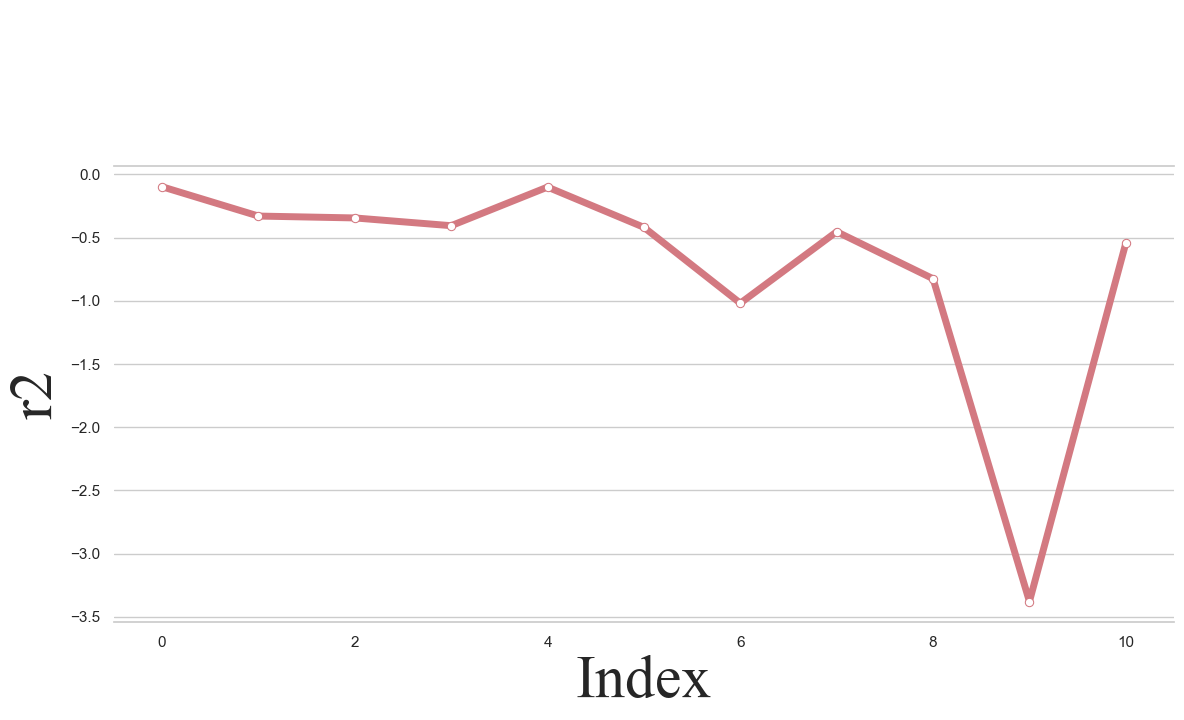

In [56]:
fig_length(metric=r2_list, metric_name='r2', dataset_name='WineDataset')

##### AirPassengersDataset

In [44]:
import time

# 模型设定
gemini_hypers = {
    'temp': 0.4,
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
    # 'gemini-pro': get_llmtime_predictions_data
}

model_names = list(model_predict_fns.keys())
datasets = get_datasets()  
datasets_tmp = get_memorization_datasets()  
datasets.update(datasets_tmp)

out_gemini_pro = {}  # gemini-pro
out_gemini_pro_number = {}  # gemini-1.0-pro

train, test = datasets['AirPassengersDataset']
dataset_name = 'AirPassengersDataset'

D:\Desktop\Works_left_over\0-已完成 (形式上)\1-Time-LLM\2-llmtime-main\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


In [45]:
n = 1  # 表示减少的周期长度数
period = 12
all_rounds = int(len(train)/period)

output_AirPassengersDataset = []  # 记录是否有该现象

for index in range(0, all_rounds):  # WineDataset 来做预测, 12 是其真实 (提前给定的) 周期
    print('Round:', index)
    train_tmp = copy.deepcopy(train)
    test_tmp = copy.deepcopy(test)
    train_tmp = train_tmp.iloc[(index*period):]
    if index > 0:
        time.sleep(60)
    for model in model_names: 
        model_hypers[model].update({'dataset_name': dataset_name})  # for promptcast, dict 添加元素
        hypers = list(grid_iter(model_hypers[model]))  # 简单理解为传参
        num_samples = 10  # 表示重复的预测的次数, 此处只是为了得到 prec
        out_gemini_pro, out_gemini_pro_number = prediction_gemini(train_tmp, test_tmp, model_hypers, num_samples=10, whether_blanket=False, dataset_name= dataset_name)

    mse_amount = 0.0
    mae_amount = 0.0
    mape_amount = 0.0
    rsquare_amount = 0.0
    for i in range(num_samples):
        seq_pred = out_gemini_pro_number[dataset_name]['samples'].iloc[i, :]
    
        mse = mean_squared_error(test_tmp, seq_pred)
        mae = mean_absolute_error(test_tmp, seq_pred)
        mape = metrics.mean_absolute_percentage_error(test_tmp, seq_pred)*100
        r2 = r2_score(test_tmp, seq_pred)
    
        mse_amount += mse
        mae_amount += mae
        mape_amount += mape
        rsquare_amount += r2
    
    mse_mean = mse_amount/num_samples
    mae_mean = mae_amount/num_samples
    mape_mean = mape_amount/num_samples
    r2_mean = rsquare_amount/num_samples
    
    # print and plot values
    print("\n")
    print('round:', index)
    print(f'MSE: {mse_mean}, MAE: {mae_mean}, MAPE: {mape_mean}, R²: {r2_mean}')
    print("\n")
    
    output_AirPassengersDataset.append({'index': index, 'mse': mse_mean, 'mae': mae_mean, 'mape': mape_mean, 'r2': r2_mean})

Round: 0
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [03:29<00:00, 209.31s/it]




round: 0
MSE: 5676.227567693534, MAE: 58.74774310344827, MAPE: 12.659093412091151, R²: 0.07015530090125577


Round: 1
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [04:02<00:00, 242.84s/it]




round: 1
MSE: 6030.373680733057, MAE: 58.68481413793106, MAPE: 12.527064637783418, R²: 0.012141262177640676


Round: 2
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [04:26<00:00, 266.45s/it]




round: 2
MSE: 5842.983757976915, MAE: 56.41817689655172, MAPE: 12.05316987804886, R²: 0.042838327131666756


Round: 3
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [03:58<00:00, 238.10s/it]




round: 3
MSE: 6038.862634401331, MAE: 57.56057241379311, MAPE: 12.16079656082923, R²: 0.010750653983165503


Round: 4
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [04:03<00:00, 243.04s/it]




round: 4
MSE: 6855.40033026897, MAE: 63.04166896551726, MAPE: 13.422910599323634, R²: -0.12300953076315169


Round: 5
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [04:03<00:00, 243.08s/it]




round: 5
MSE: 7542.819226492303, MAE: 64.88397517241383, MAPE: 13.74353440623482, R²: -0.2356182676558666


Round: 6
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [04:03<00:00, 243.45s/it]




round: 6
MSE: 5737.26062885628, MAE: 57.280786206896565, MAPE: 12.339245398919983, R²: 0.06015724009147609


Round: 7
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9






100%|██████████| 1/1 [02:51<00:00, 171.07s/it]




round: 7
MSE: 11027.932049112069, MAE: 79.07809655172414, MAPE: 16.862083445430468, R²: -0.806528021577314


Round: 8
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf






  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6


ValueError: The `response.text` quick accessor only works when the response contains a valid `Part`, but none was returned. Check the `candidate.safety_ratings` to see if the response was blocked.

In [ ]:
# o_tmp = output_AirPassengersDataset  (临时做替代来与后续对比)

# 实验笔记: Wine没有明显的上升趋势，而AirPassengersDataset有

In [50]:
output_AirPassengersDataset
all_rounds  # 总共只有9轮，目前是7轮，效果也不错了，可以进行观察看看 (不同数据集的特性不同? 效果不同？？)

11

In [57]:
mape_list_AirPassengersDataset = []
r2_list_AirPassengersDataset = []
mae_list_AirPassengersDataset = []
for dict in output_AirPassengersDataset:
    mape_list_AirPassengersDataset.append(dict['mape'])
    r2_list_AirPassengersDataset.append(dict['r2'])
    mae_list_AirPassengersDataset.append(dict['mae'])

def find_minimum_index(lst):
    min_value = min(lst)
    min_index = lst.index(min_value)
    return min_index

def find_maximum_index(lst):
    max_value = max(lst)
    max_index = lst.index(max_value)
    return max_index

argmin_mape = find_minimum_index(mape_list_AirPassengersDataset)
argmax_r2 = find_maximum_index(r2_list_AirPassengersDataset)

print(argmin_mape, argmax_r2)

2 0


In [60]:
len(r2_list_AirPassengersDataset)

8

C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


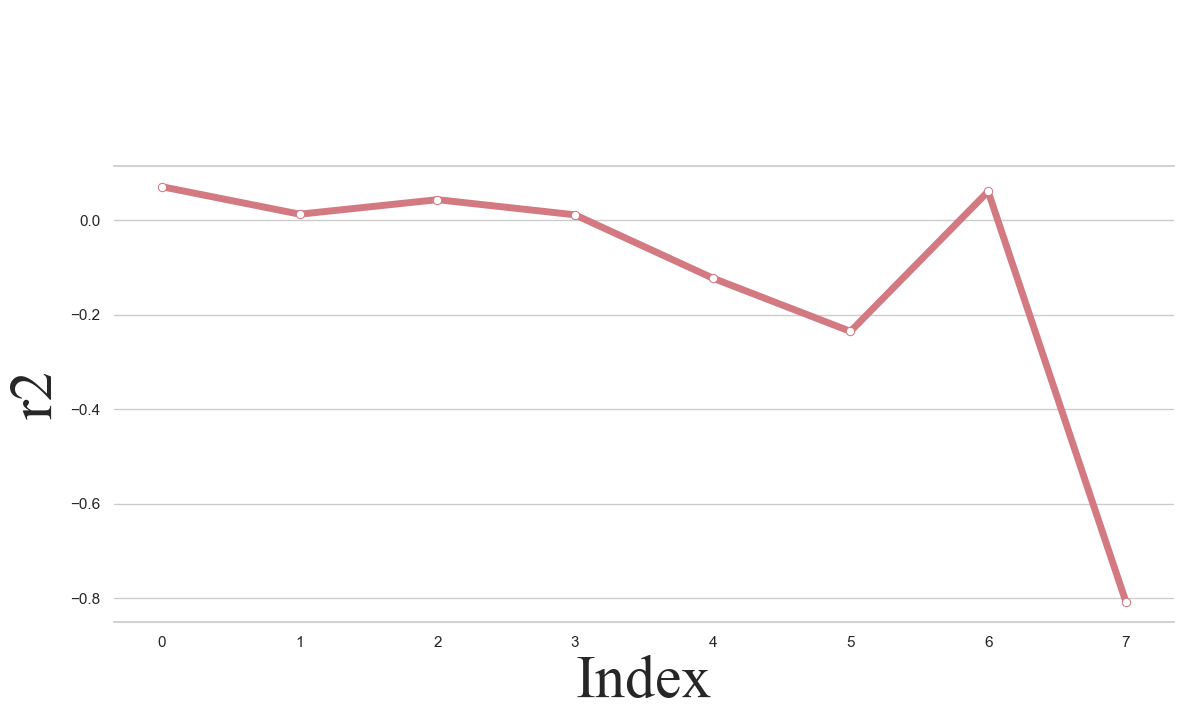

In [59]:
fig_length(metric=r2_list_AirPassengersDataset, metric_name='r2', dataset_name='AirPassengersDataset')

# 抛去一些离群点，基本可以认为随着input length上升，效果在上升 (确实长度太短了......)

##### MonthlyMilkDataset

In [46]:
import time

# 模型设定
gemini_hypers = {
    'temp': 0.4,
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
    # 'gemini-pro': get_llmtime_predictions_data
}

model_names = list(model_predict_fns.keys())
datasets = get_datasets()  
datasets_tmp = get_memorization_datasets()  
datasets.update(datasets_tmp)

out_gemini_pro = {}  # gemini-pro
out_gemini_pro_number = {}  # gemini-1.0-pro

train, test = datasets['MonthlyMilkDataset']
dataset_name = 'MonthlyMilkDataset'

D:\Desktop\Works_left_over\0-已完成 (形式上)\1-Time-LLM\2-llmtime-main\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


In [47]:
n = 1  # 表示减少的周期长度数
period = 12
all_rounds = int(len(train)/period)

output_AusBeerDataset = []  # 记录是否有该现象

for index in range(0, all_rounds):  # WineDataset 来做预测, 12 是其真实 (提前给定的) 周期
    print('Round:', index)
    train_tmp = copy.deepcopy(train)
    test_tmp = copy.deepcopy(test)
    train_tmp = train_tmp.iloc[(index*period):]
    if index > 0:
        time.sleep(60)
    for model in model_names: 
        model_hypers[model].update({'dataset_name': dataset_name})  # for promptcast, dict 添加元素
        hypers = list(grid_iter(model_hypers[model]))  # 简单理解为传参
        num_samples = 10  # 表示重复的预测的次数, 此处只是为了得到 prec
        out_gemini_pro, out_gemini_pro_number = prediction_gemini(train_tmp, test_tmp, model_hypers, num_samples=10, whether_blanket=False, dataset_name= dataset_name)

    mse_amount = 0.0
    mae_amount = 0.0
    mape_amount = 0.0
    rsquare_amount = 0.0
    for i in range(num_samples):
        seq_pred = out_gemini_pro_number[dataset_name]['samples'].iloc[i, :]
    
        mse = mean_squared_error(test_tmp, seq_pred)
        mae = mean_absolute_error(test_tmp, seq_pred)
        mape = metrics.mean_absolute_percentage_error(test_tmp, seq_pred)*100
        r2 = r2_score(test_tmp, seq_pred)
    
        mse_amount += mse
        mae_amount += mae
        mape_amount += mape
        rsquare_amount += r2
    
    mse_mean = mse_amount/num_samples
    mae_mean = mae_amount/num_samples
    mape_mean = mape_amount/num_samples
    r2_mean = rsquare_amount/num_samples
    
    # print and plot values
    print("\n")
    print('round:', index)
    print(f'MSE: {mse_mean}, MAE: {mae_mean}, MAPE: {mape_mean}, R²: {r2_mean}')
    print("\n")
    
    output_AusBeerDataset.append({'index': index, 'mse': mse_mean, 'mae': mae_mean, 'mape': mape_mean, 'r2': r2_mean})

Round: 0
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'MonthlyMilkDataset'}) 
 with NLL inf







  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9







100%|██████████| 1/1 [04:08<00:00, 248.45s/it]




round: 0
MSE: 287.3627464301185, MAE: 13.590272941176497, MAPE: 1.5903966735601898, R²: 0.9197586864639332


Round: 1
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'MonthlyMilkDataset'}) 
 with NLL inf







  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9







100%|██████████| 1/1 [04:01<00:00, 241.77s/it]




round: 1
MSE: 648.7368506367071, MAE: 15.736320000000026, MAPE: 1.8333266735952027, R²: 0.8188509203749572


Round: 2
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'MonthlyMilkDataset'}) 
 with NLL inf







  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9







100%|██████████| 1/1 [04:02<00:00, 242.14s/it]




round: 2
MSE: 936.4530412413839, MAE: 20.402363529411787, MAPE: 2.3696968572906543, R²: 0.7385109133750347


Round: 3
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'MonthlyMilkDataset'}) 
 with NLL inf







  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9







100%|██████████| 1/1 [02:05<00:00, 125.52s/it]




round: 3
MSE: 2372.007466615651, MAE: 28.413938235294154, MAPE: 3.2495514653018978, R²: 0.33765598636884037


Round: 4
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'MonthlyMilkDataset'}) 
 with NLL inf







  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9







100%|██████████| 1/1 [02:09<00:00, 129.58s/it]




round: 4
MSE: 2565.088274658795, MAE: 33.972822647058834, MAPE: 3.8938608189503867, R²: 0.2837413511266042


Round: 5
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'MonthlyMilkDataset'}) 
 with NLL inf







  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9







100%|██████████| 1/1 [02:23<00:00, 143.76s/it]




round: 5
MSE: 2698.9611984717308, MAE: 30.78860573529414, MAPE: 3.5013522905501517, R²: 0.24635954229051676


Round: 6
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'MonthlyMilkDataset'}) 
 with NLL inf







  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9







100%|██████████| 1/1 [01:35<00:00, 95.55s/it]




round: 6
MSE: 3479.843803726115, MAE: 33.88767720588238, MAPE: 3.8159648345571107, R²: 0.02831093737743947


Round: 7
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'MonthlyMilkDataset'}) 
 with NLL inf







  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9







100%|██████████| 1/1 [01:37<00:00, 97.14s/it]




round: 7
MSE: 2435.836026895532, MAE: 27.202092941176517, MAPE: 3.0775289498394462, R²: 0.31983291228703975


Round: 8
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'MonthlyMilkDataset'}) 
 with NLL inf







  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9







100%|██████████| 1/1 [02:33<00:00, 153.44s/it]




round: 8
MSE: 1230.7826976123167, MAE: 19.538732352941185, MAPE: 2.2451628789974176, R²: 0.656324204996097


Round: 9
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'MonthlyMilkDataset'}) 
 with NLL inf







  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9







100%|██████████| 1/1 [01:32<00:00, 92.59s/it]




round: 9
MSE: 8474.345272340626, MAE: 76.46170588235293, MAPE: 8.777857374449786, R²: -1.3663213289066036


Round: 10
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'MonthlyMilkDataset'}) 
 with NLL inf







  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


ValueError: The `response.text` quick accessor only works when the response contains a valid `Part`, but none was returned. Check the `candidate.safety_ratings` to see if the response was blocked.

In [48]:
mape_list_MonthlyMilkDataset = []
r2_list_MonthlyMilkDataset = []
mae_list_MonthlyMilkDataset = []
for dict in output_AusBeerDataset:
    mape_list_MonthlyMilkDataset.append(dict['mape'])
    r2_list_MonthlyMilkDataset.append(dict['r2'])
    mae_list_MonthlyMilkDataset.append(dict['mae'])

def find_minimum_index(lst):
    min_value = min(lst)
    min_index = lst.index(min_value)
    return min_index

def find_maximum_index(lst):
    max_value = max(lst)
    max_index = lst.index(max_value)
    return max_index

argmin_mape = find_minimum_index(mape_list_MonthlyMilkDataset)
argmax_r2 = find_maximum_index(r2_list_MonthlyMilkDataset)

print(argmin_mape, argmax_r2)

0 0


C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


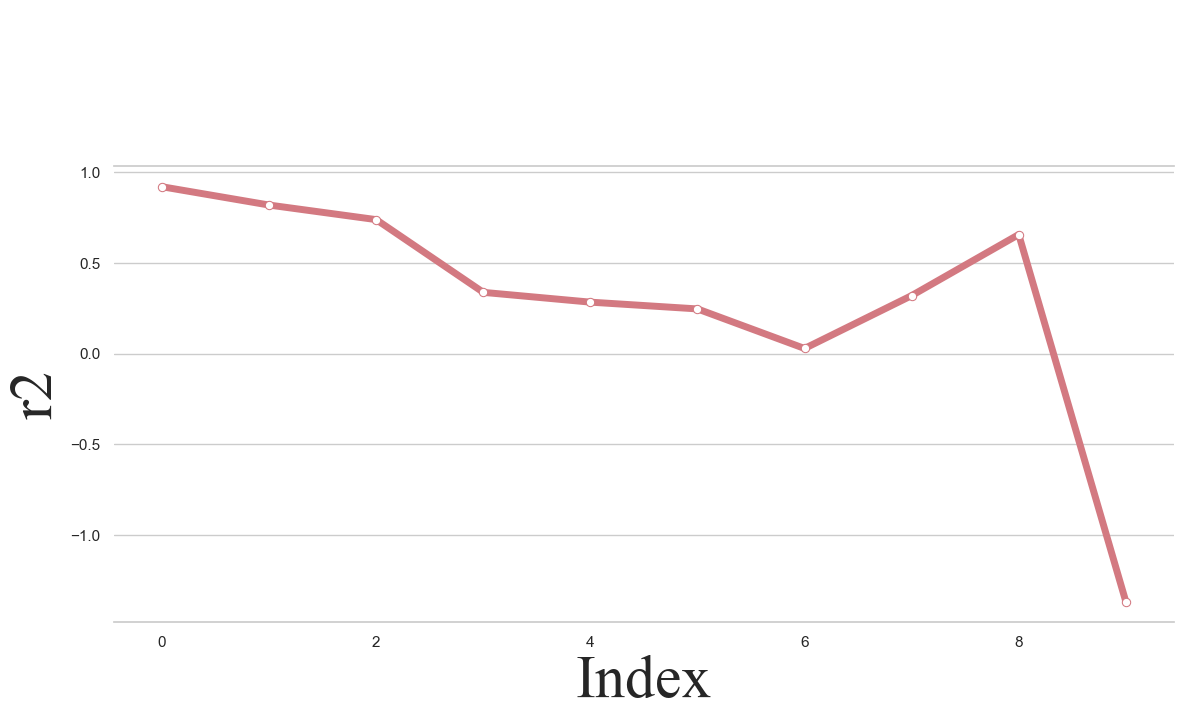

In [61]:
fig_length(metric=r2_list_MonthlyMilkDataset, metric_name='r2', dataset_name='MonthlyMilkDataset')

# 没有意义，至少在目前的长度序列来看(~300)，不会出现顶峰or最适宜的长度情况

##### GasRateCO2Dataset

In [ ]:
import time

# 模型设定
gemini_hypers = {
    'temp': 0.4,
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
    # 'gemini-pro': get_llmtime_predictions_data
}

model_names = list(model_predict_fns.keys())
datasets = get_datasets()  
datasets_tmp = get_memorization_datasets()  
datasets.update(datasets_tmp)

out_gemini_pro = {}  # gemini-pro
out_gemini_pro_number = {}  # gemini-1.0-pro

train, test = datasets['GasRateCO2Dataset']
dataset_name = 'GasRateCO2Dataset'

In [ ]:
n = 1  # 表示减少的周期长度数
period = 12
all_rounds = int(len(train)/period)

output_GasRateCO2Dataset = []  # 记录是否有该现象

for index in range(0, all_rounds):  # WineDataset 来做预测, 12 是其真实 (提前给定的) 周期
    print('Round:', index)
    train_tmp = copy.deepcopy(train)
    test_tmp = copy.deepcopy(test)
    train_tmp = train_tmp.iloc[(index*period):]
    if index > 0:
        time.sleep(60)
    for model in model_names: 
        model_hypers[model].update({'dataset_name': dataset_name})  # for promptcast, dict 添加元素
        hypers = list(grid_iter(model_hypers[model]))  # 简单理解为传参
        num_samples = 10  # 表示重复的预测的次数, 此处只是为了得到 prec
        out_gemini_pro, out_gemini_pro_number = prediction_gemini(train_tmp, test_tmp, model_hypers, num_samples=10, whether_blanket=False, dataset_name= dataset_name)

    mse_amount = 0.0
    mae_amount = 0.0
    mape_amount = 0.0
    rsquare_amount = 0.0
    for i in range(num_samples):
        seq_pred = out_gemini_pro_number[dataset_name]['samples'].iloc[i, :]
    
        mse = mean_squared_error(test_tmp, seq_pred)
        mae = mean_absolute_error(test_tmp, seq_pred)
        mape = metrics.mean_absolute_percentage_error(test_tmp, seq_pred)*100
        r2 = r2_score(test_tmp, seq_pred)
    
        mse_amount += mse
        mae_amount += mae
        mape_amount += mape
        rsquare_amount += r2
    
    mse_mean = mse_amount/num_samples
    mae_mean = mae_amount/num_samples
    mape_mean = mape_amount/num_samples
    r2_mean = rsquare_amount/num_samples
    
    # print and plot values
    print("\n")
    print('round:', index)
    print(f'MSE: {mse_mean}, MAE: {mae_mean}, MAPE: {mape_mean}, R²: {r2_mean}')
    print("\n")
    
    output_GasRateCO2Dataset.append({'index': index, 'mse': mse_mean, 'mae': mae_mean, 'mape': mape_mean, 'r2': r2_mean})

In [ ]:
mape_list_GasRateCO2Dataset = []
r2_list_GasRateCO2Dataset = []
mae_list_GasRateCO2Dataset = []
for dict in output_GasRateCO2Dataset:
    mape_list_GasRateCO2Dataset.append(dict['mape'])
    r2_list_GasRateCO2Dataset.append(dict['r2'])
    mae_list_GasRateCO2Dataset.append(dict['mae'])

def find_minimum_index(lst):
    min_value = min(lst)
    min_index = lst.index(min_value)
    return min_index

def find_maximum_index(lst):
    max_value = max(lst)
    max_index = lst.index(max_value)
    return max_index

argmin_mape = find_minimum_index(mape_list_GasRateCO2Dataset)
argmax_r2 = find_maximum_index(r2_list_GasRateCO2Dataset)

print(argmin_mape, argmax_r2)

In [ ]:
len(train)


In [ ]:
fig_length(metric=r2_list_GasRateCO2Dataset, metric_name='r2', dataset_name='IstanbulTraffic')

# 没有意义，至少在目前的长度序列来看(~300)，不会出现顶峰or最适宜的长度情况

In [ ]:
fig_length(metric=mape_list_GasRateCO2Dataset, metric_name='mape', dataset_name='IstanbulTraffic')


### Counterfactual Analysis

##### WineDataseet

In [27]:
import time
import copy

# 模型设定
gemini_hypers = {
    'temp': 0.4,
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
    # 'gemini-pro': get_llmtime_predictions_data
}

model_names = list(model_predict_fns.keys())
datasets = get_datasets()  
datasets_tmp = get_memorization_datasets()  
datasets.update(datasets_tmp)

out_gemini_pro = {}  # gemini-pro
out_gemini_pro_number = {}  # gemini-1.0-pro

dataset_name = 'WineDataset'
train, test = datasets['WineDataset']

D:\Desktop\Works_left_over\0-已完成 (形式上)\1-Time-LLM\2-llmtime-main\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


In [28]:
def adding_noise(train, loc=0, steps=4, std=5):
    # 噪声需要固定才有说服力
    np.random.seed(42)
    noise = np.random.normal(0, std, steps)
    train[loc:(loc+steps)] += noise
    return train

In [29]:
period = 12
std = 0.1*(train.max()-train.min())
num_iteration = int(len(train)/period)

out_counterfactual = {}
MSE =[]
MAE =[]
MAPE = []
R = []

for index in range(num_iteration):
    MSE_tmp =[]
    MAE_tmp =[]
    MAPE_tmp = []
    R_tmp = []
    train_tmp = copy.deepcopy(train)
    loc = index * period
    train_tmp = adding_noise(train_tmp, loc=loc, steps=period, std=std)
    if index > 0:
        time.sleep(120)
    for model in model_names: 
        model_hypers[model].update({'dataset_name': dataset_name})
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        out_gemini_pro, out_gemini_pro_number = prediction_gemini(train_tmp, test, model_hypers, num_samples=10, whether_blanket=False, dataset_name= dataset_name)
        out_counterfactual.update(out_gemini_pro_number)

    mse_amount = 0.0
    mae_amount = 0.0
    mape_amount = 0.0
    rsquare_amount = 0.0
    for i in range(num_samples):
        seq_pred = out_gemini_pro_number[dataset_name]['samples'].iloc[i, :]
    
        mse = mean_squared_error(test, seq_pred)
        mae = mean_absolute_error(test, seq_pred)
        mape = metrics.mean_absolute_percentage_error(test, seq_pred)*100
        r2 = r2_score(test, seq_pred)
    
        MSE_tmp.append(mse)
        MAE_tmp.append(mae)
        MAPE_tmp.append(mape)
        R_tmp.append(r2)
    
    MSE.append(MSE_tmp)
    MAE.append(MAE_tmp)
    MAPE.append(MAPE_tmp)
    R.append(R_tmp)



Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [04:04<00:00, 244.69s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [04:07<00:00, 247.94s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [03:31<00:00, 211.86s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [04:08<00:00, 248.90s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [04:28<00:00, 268.59s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [03:44<00:00, 224.31s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [04:03<00:00, 243.05s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [04:05<00:00, 245.88s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [03:31<00:00, 211.09s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [04:01<00:00, 241.54s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [04:28<00:00, 268.31s/it]


In [30]:
len(R)

11

In [31]:
def plot_scatter_2d_list(data):
    m = len(data)  # 第一维的长度
    n = len(data[0])  # 第二维的长度

    # 初始化x和y坐标
    x_coords = []
    y_coords = []

    # 遍历二维列表，提取x和y坐标
    for i in range(m):
        for j in range(n):
            x_coords.append(i)  # x轴为第一维m
            y_coords.append(data[i][j])  # y轴为二维列表中的值

    # 绘制散点图
    plt.scatter(x_coords, y_coords)

def fig_counterfactual(metric, metric_name='R^2', dataset_name='WineDataset'):
    '''
    Args:
        metric: two-dimensional list 
        metric_name: 
        dataset_name: 

    Returns:

    '''
    font_path = fm.findfont(fm.FontProperties(family='Times New Roman'))
    font_prop = fm.FontProperties(fname=font_path)
    _font_size = 38
    sns.set_style('whitegrid')
    sns.set(style="whitegrid", rc={"axes.grid.axis": "y", "axes.grid": True})
    fig = plt.figure(figsize=(12,8))
    ax1 = plt.gca()
    x = np.arange(len(metric))
    metric_mean = [sum(sublist) / len(sublist) for sublist in metric]

    sns.lineplot(x=x, y=metric_mean, color='#d37981', alpha=1, linewidth=5, marker='o',markerfacecolor='w',markeredgecolor='#d37981', markersize=6)
    lower = np.quantile(metric, 0.05, axis=1)
    upper = np.quantile(metric, 0.95, axis=1)
    plt.fill_between(x, lower, upper, alpha=0.3, color='purple')
    plot_scatter_2d_list(data=metric)
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    plt.xlabel("Index", fontproperties=font_prop, fontsize=_font_size+5)
    plt.ylabel(metric_name, fontproperties=font_prop, fontsize=_font_size+5)
    plt.legend(bbox_to_anchor=(0.5, 1.4), loc='upper center',fontsize=_font_size)
    plt.tight_layout()
    plt.savefig(f"Counterfactual Analysis_0407_{dataset_name}.png")
    plt.show()

C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


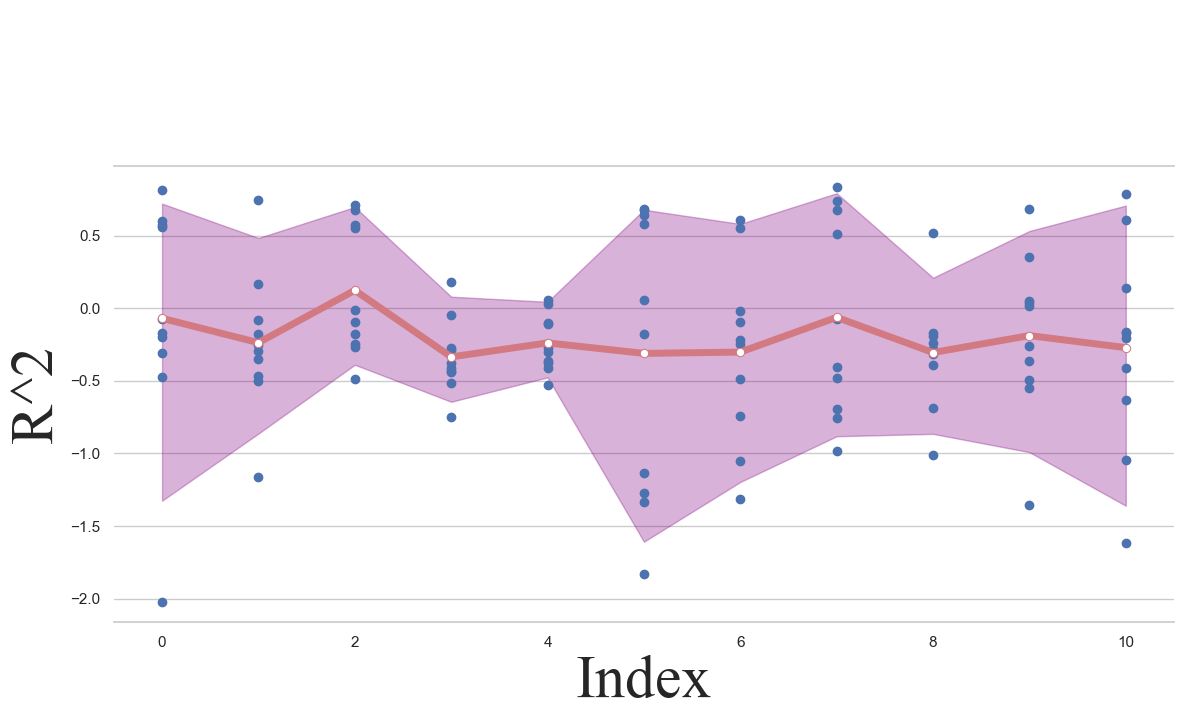

In [32]:
fig_counterfactual(R, metric_name='R^2', dataset_name='WineDataset')

##### AirPassengersDataset

In [19]:
import time

# 模型设定
gemini_hypers = {
    'temp': 0.4,
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
    # 'gemini-pro': get_llmtime_predictions_data
}

model_names = list(model_predict_fns.keys())
datasets = get_datasets()  
datasets_tmp = get_memorization_datasets()  
datasets.update(datasets_tmp)

out_gemini_pro = {}  # gemini-pro
out_gemini_pro_number = {}  # gemini-1.0-pro

dataset_name = 'AirPassengersDataset'
train, test = datasets['AirPassengersDataset']

D:\Desktop\Works_left_over\0-已完成 (形式上)\1-Time-LLM\2-llmtime-main\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


In [24]:
period = 12
std = 0.1*(train.max()-train.min())
num_iteration = int(len(train)/period)

out_counterfactual = {}
MSE =[]
MAE =[]
MAPE = []
R = []

for index in range(num_iteration):
    MSE_tmp =[]
    MAE_tmp =[]
    MAPE_tmp = []
    R_tmp = []
    train_tmp = copy.deepcopy(train)
    loc = index * period
    train_tmp = adding_noise(train_tmp, loc=loc, steps=period, std=std)
    if index > 0:
        time.sleep(60)
    for model in model_names: 
        model_hypers[model].update({'dataset_name': dataset_name})
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        out_gemini_pro, out_gemini_pro_number = prediction_gemini(train_tmp, test, model_hypers, num_samples=10, whether_blanket=False, dataset_name= dataset_name)
        out_counterfactual.update(out_gemini_pro_number)

    mse_amount = 0.0
    mae_amount = 0.0
    mape_amount = 0.0
    rsquare_amount = 0.0
    for i in range(num_samples):
        seq_pred = out_gemini_pro_number[dataset_name]['samples'].iloc[i, :]
    
        mse = mean_squared_error(test, seq_pred)
        mae = mean_absolute_error(test, seq_pred)
        mape = metrics.mean_absolute_percentage_error(test, seq_pred)*100
        r2 = r2_score(test, seq_pred)
    
        MSE_tmp.append(mse)
        MAE_tmp.append(mae)
        MAPE_tmp.append(mape)
        R_tmp.append(r2)
    
    MSE.append(MSE_tmp)
    MAE.append(MAE_tmp)
    MAPE.append(MAPE_tmp)
    R.append(R_tmp)



Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [04:10<00:00, 250.94s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [04:24<00:00, 264.47s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [03:30<00:00, 210.94s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [03:16<00:00, 196.55s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [03:44<00:00, 224.38s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [04:08<00:00, 248.78s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [03:54<00:00, 234.92s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [04:28<00:00, 268.85s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf





  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9





100%|██████████| 1/1 [04:27<00:00, 267.75s/it]


In [25]:
len(R)

9

C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


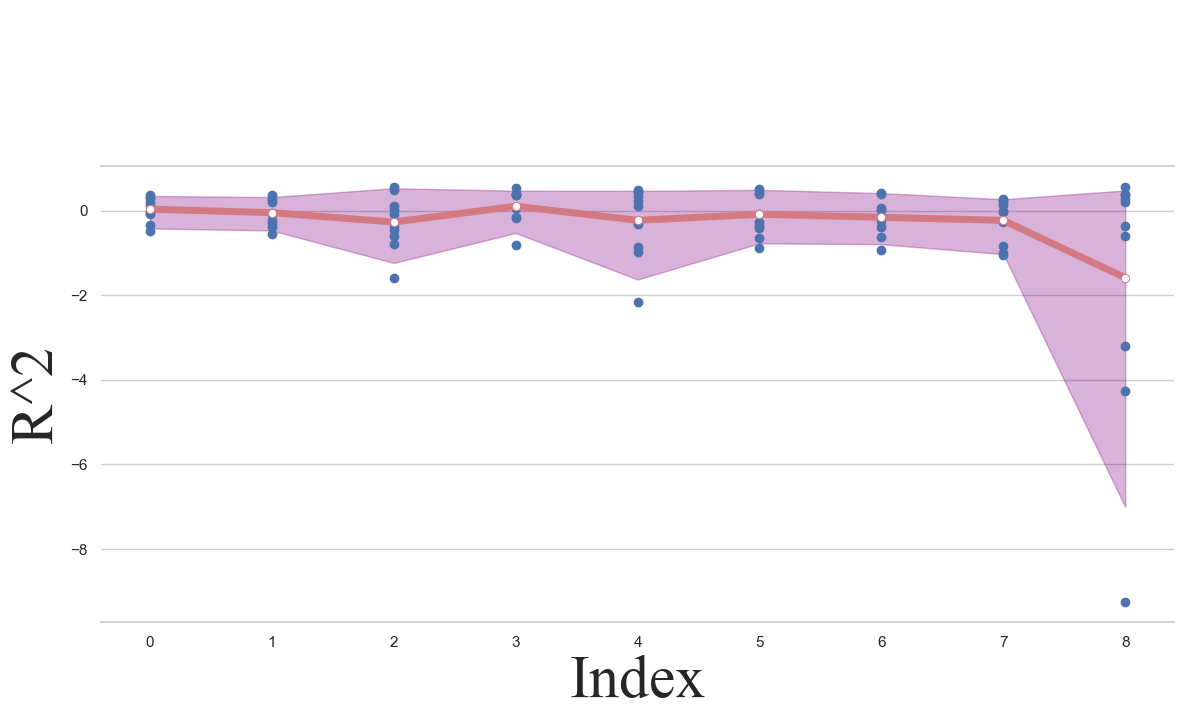

In [26]:
fig_counterfactual(R, metric_name='R^2', dataset_name='AirPassengersDataset')

In [ ]:
# 似乎观察发现对于长序列，中间部分的扰动带来的影响会比较小，两边的会比较大（这个是一个有趣的观察现象）_这个总会实现的，因为总会有大有小




##### GasRateCO2Dataset

In [83]:
import time

# 模型设定
gemini_hypers = {
    'temp': 0.4,
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
    # 'gemini-pro': get_llmtime_predictions_data
}

model_names = list(model_predict_fns.keys())
datasets = get_datasets()  
datasets_tmp = get_memorization_datasets()  
datasets.update(datasets_tmp)

out_gemini_pro = {}  # gemini-pro
out_gemini_pro_number = {}  # gemini-1.0-pro

dataset_name = 'GasRateCO2Dataset'
train, test = datasets['GasRateCO2Dataset']

D:\Desktop\Works_left_over\0-已完成 (形式上)\1-Time-LLM\2-llmtime-main\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


In [84]:
datasets.keys()

dict_keys(['AirPassengersDataset', 'AusBeerDataset', 'GasRateCO2Dataset', 'MonthlyMilkDataset', 'SunspotsDataset', 'WineDataset', 'WoolyDataset', 'HeartRateDataset', 'IstanbulTraffic', 'TSMCStock', 'TurkeyPower'])

In [89]:
period = 6  # 这里随便设定
std = 0.1*(train.max()-train.min())
num_iteration = int(len(train)/period)

out_counterfactual = {}
MSE =[]
MAE =[]
MAPE = []
R = []

for index in range(num_iteration):
    MSE_tmp =[]
    MAE_tmp =[]
    MAPE_tmp = []
    R_tmp = []
    train_tmp = copy.deepcopy(train)
    loc = index * period
    train_tmp = adding_noise(train_tmp, loc=loc, steps=period, std=std)
    if index > 0:
        time.sleep(60)
    for model in model_names: 
        model_hypers[model].update({'dataset_name': dataset_name})
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        out_gemini_pro, out_gemini_pro_number = prediction_gemini(train_tmp, test, model_hypers, num_samples=10, whether_blanket=False, dataset_name= dataset_name)
        out_counterfactual.update(out_gemini_pro_number)

    mse_amount = 0.0
    mae_amount = 0.0
    mape_amount = 0.0
    rsquare_amount = 0.0
    for i in range(num_samples):
        seq_pred = out_gemini_pro_number[dataset_name]['samples'].iloc[i, :]
    
        mse = mean_squared_error(test, seq_pred)
        mae = mean_absolute_error(test, seq_pred)
        mape = metrics.mean_absolute_percentage_error(test, seq_pred)*100
        r2 = r2_score(test, seq_pred)
    
        MSE_tmp.append(mse)
        MAE_tmp.append(mae)
        MAPE_tmp.append(mape)
        R_tmp.append(r2)
    
    MSE.append(MSE_tmp)
    MAE.append(MAE_tmp)
    MAPE.append(MAPE_tmp)
    R.append(R_tmp)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:30<00:00, 210.07s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:15<00:00, 195.40s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:56<00:00, 236.34s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:13<00:00, 193.74s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [02:47<00:00, 167.55s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:32<00:00, 212.04s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:08<00:00, 188.36s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [02:57<00:00, 177.88s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:18<00:00, 198.98s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [02:30<00:00, 150.06s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [02:43<00:00, 163.54s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:00<00:00, 180.77s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:19<00:00, 199.29s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:13<00:00, 193.12s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:10<00:00, 190.78s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:31<00:00, 211.26s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:31<00:00, 211.68s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:17<00:00, 197.20s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [02:56<00:00, 176.42s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [02:57<00:00, 177.81s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:01<00:00, 181.55s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [02:47<00:00, 167.12s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:12<00:00, 192.11s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:30<00:00, 210.85s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [02:34<00:00, 154.45s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:13<00:00, 193.70s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:01<00:00, 181.79s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [02:38<00:00, 158.55s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:21<00:00, 201.54s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:03<00:00, 183.91s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [02:47<00:00, 167.35s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [02:50<00:00, 170.42s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [02:45<00:00, 165.05s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [03:03<00:00, 183.71s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9


100%|██████████| 1/1 [02:44<00:00, 164.29s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'GasRateCO2Dataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2


ProxyError: HTTPSConnectionPool(host='generativelanguage.googleapis.com', port=443): Max retries exceeded with url: /v1beta/models/gemini-1.0-pro:generateContent?%24alt=json%3Benum-encoding%3Dint (Caused by ProxyError('Cannot connect to proxy.', RemoteDisconnected('Remote end closed connection without response')))

In [96]:
len(R)
len(R)*period
period  # 最后四组(有趣，只有四组有影响......)

6

C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


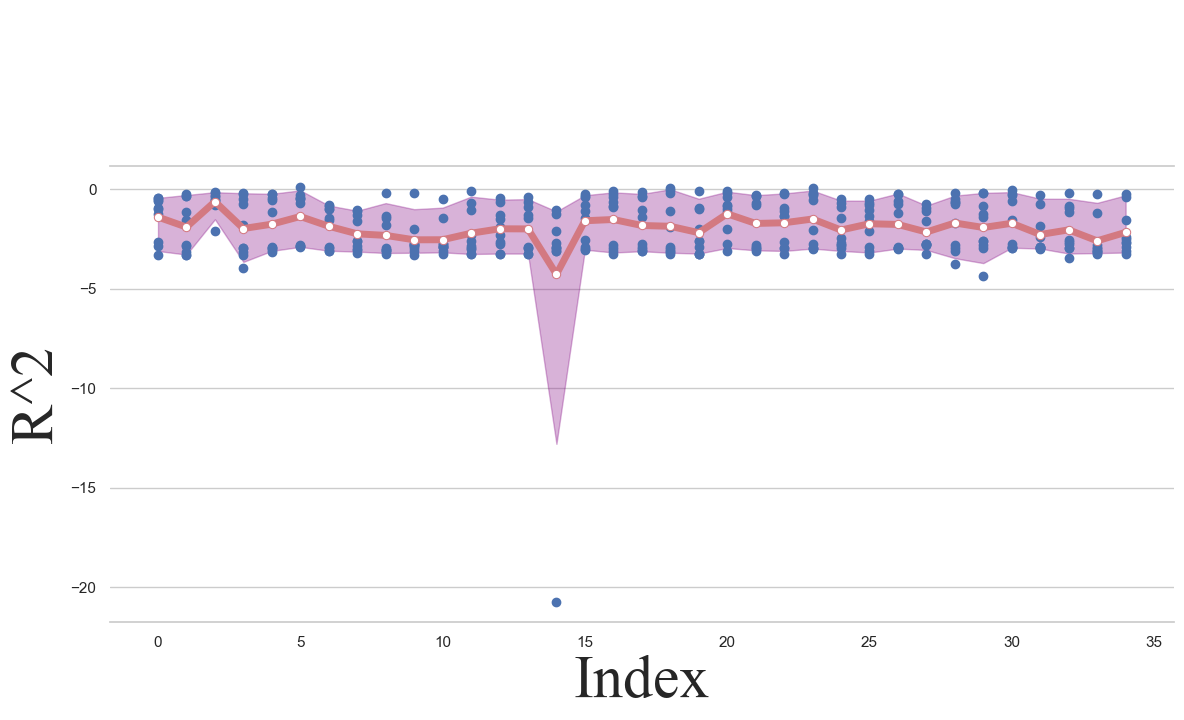

In [91]:
fig_counterfactual(R, metric_name='R^2', dataset_name='IstanbulTraffic')
# 这里应该是GasRateCO2Dataset，还没改(这里最后还差一点没做，不过结论是......前面的内容修改基本没影响

##### Ausbeer

In [69]:
import time

# 模型设定
gemini_hypers = {
    'temp': 0.4,
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
    # 'gemini-pro': get_llmtime_predictions_data
}

model_names = list(model_predict_fns.keys())
datasets = get_datasets()  
datasets_tmp = get_memorization_datasets()  
datasets.update(datasets_tmp)

out_gemini_pro = {}  # gemini-pro
out_gemini_pro_number = {}  # gemini-1.0-pro

dataset_name = 'AusBeerDataset'
train, test = datasets['AusBeerDataset']

D:\Desktop\Works_left_over\0-已完成 (形式上)\1-Time-LLM\2-llmtime-main\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


In [70]:
period = 4
std = 0.1*(train.max()-train.min())
num_iteration = int(len(train)/period)

out_counterfactual = {}
MSE =[]
MAE =[]
MAPE = []
R = []

for index in range(num_iteration):
    MSE_tmp =[]
    MAE_tmp =[]
    MAPE_tmp = []
    R_tmp = []
    train_tmp = copy.deepcopy(train)
    loc = index * period
    train_tmp = adding_noise(train_tmp, loc=loc, steps=period, std=std)
    if index > 0:
        time.sleep(60)
    for model in model_names: 
        model_hypers[model].update({'dataset_name': dataset_name})
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        out_gemini_pro, out_gemini_pro_number = prediction_gemini(train_tmp, test, model_hypers, num_samples=10, whether_blanket=False, dataset_name= dataset_name)
        out_counterfactual.update(out_gemini_pro_number)

    mse_amount = 0.0
    mae_amount = 0.0
    mape_amount = 0.0
    rsquare_amount = 0.0
    for i in range(num_samples):
        seq_pred = out_gemini_pro_number[dataset_name]['samples'].iloc[i, :]
    
        mse = mean_squared_error(test, seq_pred)
        mae = mean_absolute_error(test, seq_pred)
        mape = metrics.mean_absolute_percentage_error(test, seq_pred)*100
        r2 = r2_score(test, seq_pred)
    
        MSE_tmp.append(mse)
        MAE_tmp.append(mae)
        MAPE_tmp.append(mape)
        R_tmp.append(r2)
    
    MSE.append(MSE_tmp)
    MAE.append(MAE_tmp)
    MAPE.append(MAPE_tmp)
    R.append(R_tmp)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:27<00:00, 267.24s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:26<00:00, 266.84s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:27<00:00, 267.10s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:27<00:00, 267.15s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [03:58<00:00, 238.71s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:26<00:00, 266.49s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:17<00:00, 257.51s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:14<00:00, 254.62s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:08<00:00, 248.24s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:26<00:00, 266.50s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:26<00:00, 266.68s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:27<00:00, 267.63s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:27<00:00, 267.79s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:27<00:00, 267.07s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:27<00:00, 267.16s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:26<00:00, 266.73s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:15<00:00, 255.62s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:27<00:00, 267.13s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:14<00:00, 254.34s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:17<00:00, 257.26s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:27<00:00, 267.17s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:27<00:00, 267.51s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:18<00:00, 258.58s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:10<00:00, 250.20s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:07<00:00, 247.17s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:28<00:00, 268.00s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:28<00:00, 268.40s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:09<00:00, 249.23s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:27<00:00, 267.70s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:29<00:00, 269.14s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:11<00:00, 251.98s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:24<00:00, 264.93s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [03:44<00:00, 224.54s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:02<00:00, 242.67s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [03:48<00:00, 228.41s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:28<00:00, 268.68s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [03:59<00:00, 239.15s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:27<00:00, 267.35s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:27<00:00, 267.20s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:10<00:00, 250.88s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:27<00:00, 267.18s/it]


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.4, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AusBeerDataset'}) 
 with NLL inf











  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9











100%|██████████| 1/1 [04:27<00:00, 267.02s/it]


In [71]:
len(R)

42

C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\TH\anaconda3\envs\llmtime\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


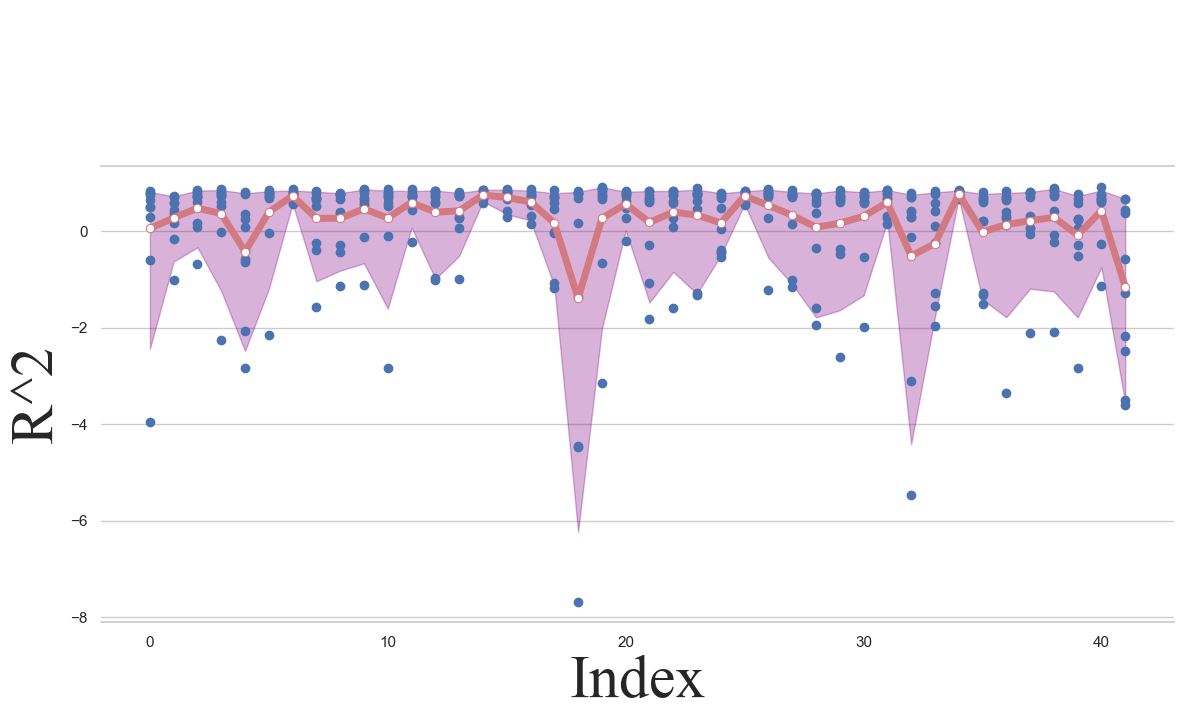

In [72]:
fig_counterfactual(R, metric_name='R^2', dataset_name='AirPassengersDataset')

In [ ]:
# 似乎可以说明，不需要过长的链条？？——那如果是完全未知周期的链条呢？这个很明晰过往的信息也需要知道，但似乎会被忽略掉？？
# 如果能说明大模型对于时间序列的推理局限在于附近的部分点的话，那么结果.....也还行（说明不会关注之前的信息）
# 这是缺点，也是我们可以压缩时间序列输入的方法 (更多关注 ≠ 完全只关注
# 对于更长期的趋势，可能无法实现预测 —— 形式上拉长test set，将output length拉长，看后面的结果如何

# 剥离了长度的概念，使得其和模型表现没有联系

#### 拉长预测序列长度，看实验现象

[]